# READ THIS BEFORE YOU START, OCTOBER 23

We now have data compiled for several cities at the end. For your presentation at the JMM climate change exhibit, you can use any or all of those, as well as any or all of the plots from the two articles linked below.

 - Nail down your final list of changes you'd like to make to the plots [I made some of the suggested changes, e.g. making the blue dots larger and lower; I can make the others when you agree]. Do this as a team. Then, if possible, agree on a single standard as a class.
 - If, as a class, there are other cities you really want, email me.
 - As a class, agree on what you think the figure legend/key should look like. Draw a picture. Send me the picture, complete with explanations.
 - As teams, send me a document detailing what you plan on presenting.
 
Please note that not all of the cities below have been fully validated by the Data Science students. Here are their notes:

NYC: This data was perfect

Muncie, IN: this had reasonable records, merged with Indianapolis

Indianapolis: perfect data

Lawrence, KS: Lots of data missing, original had lots of record highs and lows, merged with topeka

Princeton, NJ: perfect data

Chicago,IL: 3 days missing, not same as Evanston, merged with Evanston


# Visualizing the weather!

1. Read Randal Olson's [article](http://fivethirtyeight.com/features/what-12-months-of-record-setting-temperatures-looks-like-across-the-u-s/) on 538.
2. Read his blog about [making the plots](http://www.randalolson.com/2015/08/13/the-new-york-times-weather-chart-redux/)

Now check out the code below. You're **NOT** expected to understand, read and write Python code for this course! We will be tweaking it a bit to do what you want, though!

**Instructor note: everybody runs everything through the scraping right now, so it can scrape while we're talking.**

In [1]:
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Grabbing the data

First, we need to grab the data from Wunderground. You can find historical data on pages like [this](http://www.wunderground.com/history/airport/KVES/2015/10/14/DailyHistory.html?req_city=Richmond&req_state=IN&reqdb.zip=47374&reqdb.magic=1&reqdb.wmo=99999).

Looking through each of those and writing down all of the values would be a *giant* pain. So, we do what's called "web scraping" to automate the process. It looks like this:

In [2]:
def scrape_station(station):
    '''
    This function scrapes the weather data web pages from wunderground.com
    for the station you provide it.
    You can look up your city's weather station by performing a search for
    it on wunderground.com then clicking on the "History" section.
    The 4-letter name of the station will appear on that page.
    '''

    # Scrape between July 1, 2014 and July 1, 2015
    # You can change the dates here if you prefer to scrape a different range
    current_date = datetime(year=2014, month=7, day=1)
    end_date = datetime(year=2015, month=7, day=1)

    # Make sure a directory exists for the station web pages
    os.mkdir(station)

    # Use .format(station, YYYY, M, D)
    lookup_URL = 'http://www.wunderground.com/history/airport/{}/{}/{}/{}/DailyHistory.html'

    while current_date != end_date:

        if current_date.day == 1:
            print(current_date)

        formatted_lookup_URL = lookup_URL.format(station,
                                                 current_date.year,
                                                 current_date.month,
                                                 current_date.day)
        html = urlopen(formatted_lookup_URL).read().decode('utf-8')

        out_file_name = '{}/{}-{}-{}.html'.format(station, current_date.year,
                                                  current_date.month,
                                                  current_date.day)

        with open(out_file_name, 'w') as out_file:
            out_file.write(html)

        current_date += timedelta(days=1)

### Grabbing Richmond's data

We could then grab Richmond's data with the following:

In [ ]:
scrape_station('KVES')

## Parsing

That grabs the raw web pages.

We then need to make sense of the above information.

In [3]:
def parse_station(station):
    '''
    This function parses the web pages downloaded from wunderground.com
    into a flat CSV file for the station you provide it.

    Make sure to run the wunderground scraper first so you have the web
    pages downloaded.
    '''

    # Scrape between July 1, 2014 and July 1, 2015
    # You can change the dates here if you prefer to parse a different range
    current_date = datetime(year=2014, month=7, day=1)
    end_date = datetime(year=2015, month=7, day=1)

    with open('{}.csv'.format(station), 'w') as out_file:
        out_file.write('date,actual_mean_temp,actual_min_temp,actual_max_temp,'
                       'average_min_temp,average_max_temp,'
                       'record_min_temp,record_max_temp,'
                       'record_min_temp_year,record_max_temp_year,'
                       'actual_precipitation,average_precipitation,'
                       'record_precipitation\n')

        while current_date != end_date:
            try_again = False
            with open('{}/{}-{}-{}.html'.format(station,
                                                current_date.year,
                                                current_date.month,
                                                current_date.day)) as in_file:
                soup = BeautifulSoup(in_file.read(), 'html.parser')

                weather_data = soup.find(id='historyTable').find_all('span', class_='wx-value')
                weather_data_units = soup.find(id='historyTable').find_all('td')

                try:
                    actual_mean_temp = weather_data[0].text
                    actual_max_temp = weather_data[2].text
                    average_max_temp = weather_data[3].text
                    record_max_temp = weather_data[4].text
                    actual_min_temp = weather_data[5].text
                    average_min_temp = weather_data[6].text
                    record_min_temp = weather_data[7].text
                    record_max_temp_year = weather_data_units[
                        9].text.split('(')[-1].strip(')')
                    record_min_temp_year = weather_data_units[
                        13].text.split('(')[-1].strip(')')

                    actual_precipitation = weather_data[9].text
                    if actual_precipitation == 'T':
                        actual_precipitation = '0.0'
                    average_precipitation = weather_data[10].text
                    record_precipitation = weather_data[11].text

                    # Verify that the parsed data is valid
                    if (record_max_temp_year == '-1' or record_min_temp_year == '-1' or
                            int(record_max_temp) < max(int(actual_max_temp), int(average_max_temp)) or
                            int(record_min_temp) > min(int(actual_min_temp), int(average_min_temp)) or
                            float(actual_precipitation) > float(record_precipitation) or
                            float(average_precipitation) > float(record_precipitation)):
                        raise Exception

                    out_file.write('{}-{}-{},'.format(current_date.year, current_date.month, current_date.day))
                    out_file.write(','.join([actual_mean_temp, actual_min_temp, actual_max_temp,
                                             average_min_temp, average_max_temp,
                                             record_min_temp, record_max_temp,
                                             record_min_temp_year, record_max_temp_year,
                                             actual_precipitation, average_precipitation,
                                             record_precipitation]))
                    out_file.write('\n')
                    current_date += timedelta(days=1)
                except:
                    # If the web page is formatted improperly, signal that the page may need
                    # to be downloaded again.
                    try_again = True

            # If the web page needs to be downloaded again, re-download it from
            # wunderground.com

            # If the parser gets stuck on a certain date, you may need to investigate
            # the page to find out what is going on. Sometimes data is missing, in
            # which case the parser will get stuck. You can manually put in the data
            # yourself in that case, or just tell the parser to skip this day.
            if try_again:
                
                print('Error with date {}'.format(current_date))
                
                actual_mean_temp = '0.0'
                actual_max_temp = '0.0'
                average_max_temp = '0.0'
                record_max_temp = '0.0'
                actual_min_temp = '0.0'
                average_min_temp = '0.0'
                record_min_temp = '0.0'
                record_max_temp_year = '0.0'
                record_min_temp_year = '0.0'

                actual_precipitation = '0.0'
                average_precipitation = '0.0'
                record_precipitation = '0.0'

                out_file.write('{}-{}-{},'.format(current_date.year, current_date.month, current_date.day))
                out_file.write(','.join([actual_mean_temp, actual_min_temp, actual_max_temp,
                                         average_min_temp, average_max_temp,
                                         record_min_temp, record_max_temp,
                                         record_min_temp_year, record_max_temp_year,
                                         actual_precipitation, average_precipitation,
                                         record_precipitation]))
                out_file.write('\n')
                current_date += timedelta(days=1)

In [ ]:
parse_station('KVES')

## Visualize!

Now let's make some pretty plots!

In [4]:
def visualize_station(station):
    weather_data = pd.read_csv(station+'.csv', parse_dates=['date'])
    print(weather_data.describe())

    # Generate a bunch of histograms of the data to make sure that all of the data
    # is in an expected range.

    '''
    I also use a custom matplotlib style as the basis for these charts, which you
    can find here: https://gist.githubusercontent.com/rhiever/d0a7332fe0beebfdc3d5/raw/223d70799b48131d5ce2723cd5784f39d7a3a653/tableau10.mplstyle
    '''

    with plt.style.context('https://gist.githubusercontent.com/rhiever/d0a7332fe0beebfdc3d5/raw/223d70799b48131d5ce2723cd5784f39d7a3a653/tableau10.mplstyle'):
        for column in weather_data.columns:
            if column in ['date']:
                continue
            plt.figure()
            plt.hist(weather_data[column].values)
            plt.title(column)
            plt.savefig('{}.png'.format(column))

        # Make sure we're only plotting temperatures for July 2014 - June 2015
        weather_data_subset = weather_data[weather_data['date'] >= datetime(year=2014, month=7, day=1)]
        weather_data_subset = weather_data_subset[weather_data_subset['date'] < datetime(year=2015, month=6, day=30)].copy()
        weather_data_subset['day_order'] = range(len(weather_data_subset))

        day_order = weather_data_subset['day_order']
        record_max_temps = weather_data_subset['record_max_temp'].values
        record_min_temps = weather_data_subset['record_min_temp'].values
        average_max_temps = weather_data_subset['average_max_temp'].values
        average_min_temps = weather_data_subset['average_min_temp'].values
        actual_max_temps = weather_data_subset['actual_max_temp'].values
        actual_min_temps = weather_data_subset['actual_min_temp'].values

        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Create the bars showing all-time record highs and lows
        plt.bar(day_order, record_max_temps - record_min_temps, bottom=record_min_temps,
                edgecolor='none', color='#C3BBA4', width=1)

        # Create the bars showing average highs and lows
        plt.bar(day_order, average_max_temps - average_min_temps, bottom=average_min_temps,
                edgecolor='none', color='#9A9180', width=1)

        # Create the bars showing this year's highs and lows
        plt.bar(day_order, actual_max_temps - actual_min_temps, bottom=actual_min_temps,
                edgecolor='black', linewidth=0.5, color='#5A3B49', width=1)

        new_max_records = weather_data_subset[weather_data_subset.record_max_temp <= weather_data_subset.actual_max_temp]
        new_min_records = weather_data_subset[weather_data_subset.record_min_temp >= weather_data_subset.actual_min_temp]
        
        circle_size= 40
        horizontal_offset = 0.6
#        horizontal_offset = 0.75
        vertical_offset = 1.25
        vertical_offset = 4.0

        # Create the dots marking record highs and lows for the year
        plt.scatter(new_max_records['day_order'].values + horizontal_offset,
                    new_max_records['actual_max_temp'].values + vertical_offset,
                    s=circle_size, zorder=10, color='#d62728', alpha=0.75, linewidth=0)

        plt.scatter(new_min_records['day_order'].values + horizontal_offset,
                    new_min_records['actual_min_temp'].values - vertical_offset,
                    s=circle_size, zorder=10, color='#1f77b4', alpha=0.75, linewidth=0)

        plt.ylim(-50, 141)
        plt.xlim(-5, 370)

        plt.yticks(range(-50, 141, 10), [r'{}$^\circ$'.format(x)
                                         for x in range(-50, 141, 10)], fontsize=10)
        plt.ylabel(r'Temperature ($^\circ$F)', fontsize=12)

        month_beginning_df = weather_data_subset[weather_data_subset['date'].apply(lambda x: True if x.day == 1 else False)]
        month_beginning_indeces = list(month_beginning_df['day_order'].values)
        month_beginning_names = list(month_beginning_df['date'].apply(lambda x: x.strftime("%B")).values)
        month_beginning_names[0] += '\n\'14'
        month_beginning_names[6] += '\n\'15'

        # Add the last month label manually
        month_beginning_indeces += [weather_data_subset['day_order'].values[-1]]
        month_beginning_names += ['July']

        plt.xticks(month_beginning_indeces,
                   month_beginning_names,
                   fontsize=10)

        ax2 = ax1.twiny()
        plt.xticks(month_beginning_indeces,
                   month_beginning_names,
                   fontsize=10)

        plt.xlim(-5, 370)
        plt.grid(False)

        ax3 = ax1.twinx()
        plt.yticks(range(-50, 141, 10), [r'{}$^\circ$'.format(x)
                                         for x in range(-50, 141, 10)], fontsize=10)
        plt.ylim(-50, 141)
        plt.grid(False)

        plt.title(station+'\'s weather, July 2014 - June 2015\n\n', fontsize=20)

        plt.savefig(station+'-weather-july14-june15.png')
        plt.show()

## KVES: Richmond Indiana

       Unnamed: 0  actual_mean_temp  actual_min_temp  actual_max_temp  \
count  365.000000        365.000000       365.000000       365.000000   
mean   182.000000         48.791781        39.558904        57.890411   
std    105.510663         19.210100        18.522928        20.643868   
min      0.000000          2.000000        -7.000000         8.000000   
25%     91.000000         33.000000        27.000000        41.000000   
50%    182.000000         50.000000        41.000000        60.000000   
75%    273.000000         66.000000        55.000000        78.000000   
max    364.000000         78.000000        72.000000        89.000000   

       average_min_temp  average_max_temp  record_min_temp  record_max_temp  \
count        365.000000        365.000000       365.000000       365.000000   
mean          42.991781         61.301370        20.452055        84.142466   
std           15.673609         17.519757        22.413841        13.414625   
min           20.000000   

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


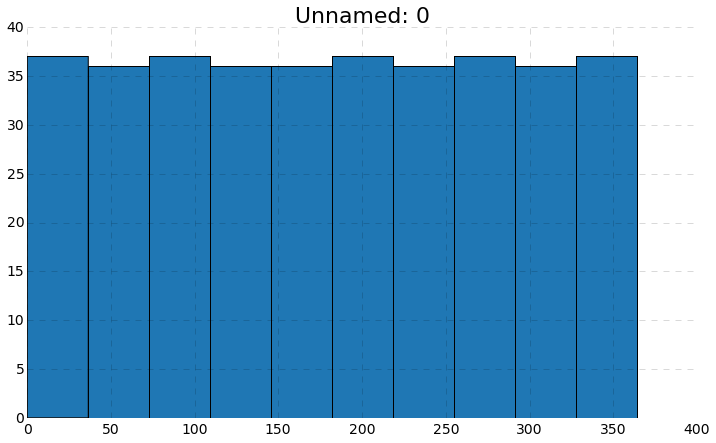

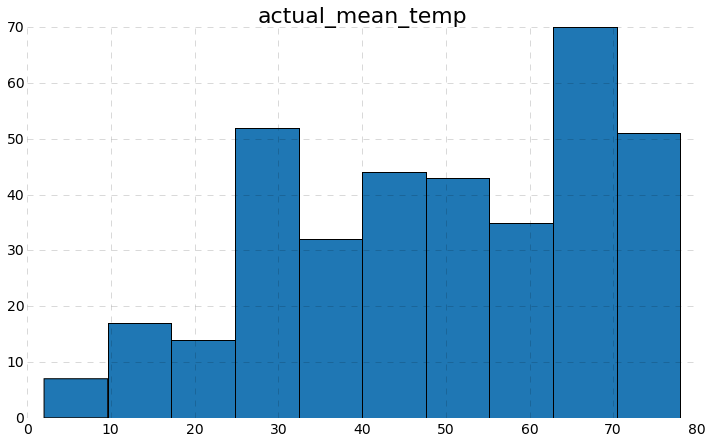

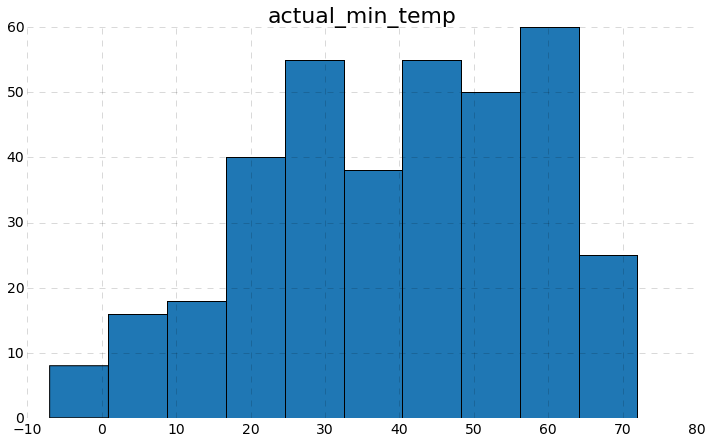

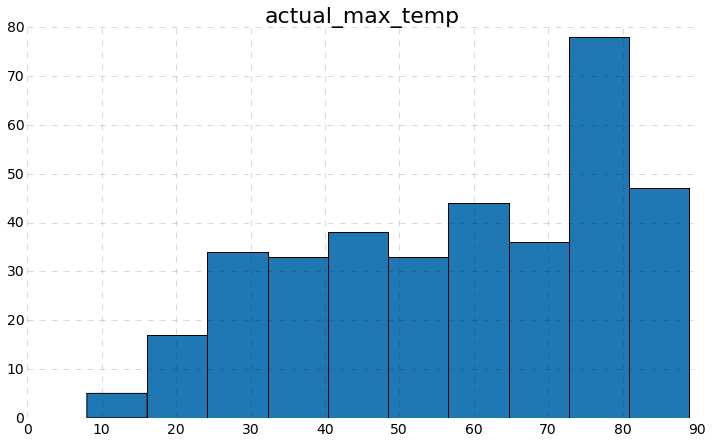

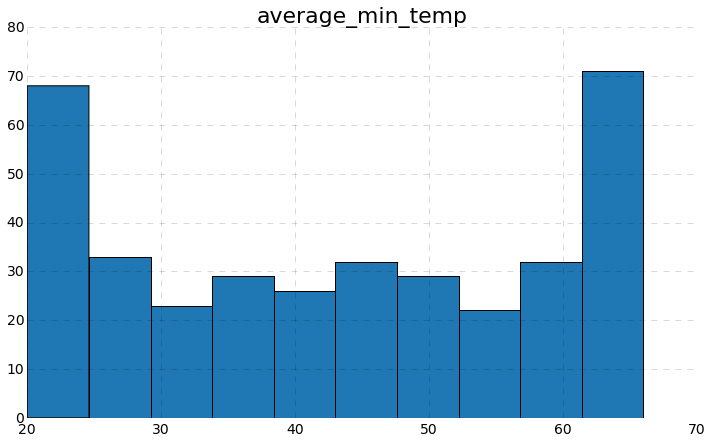

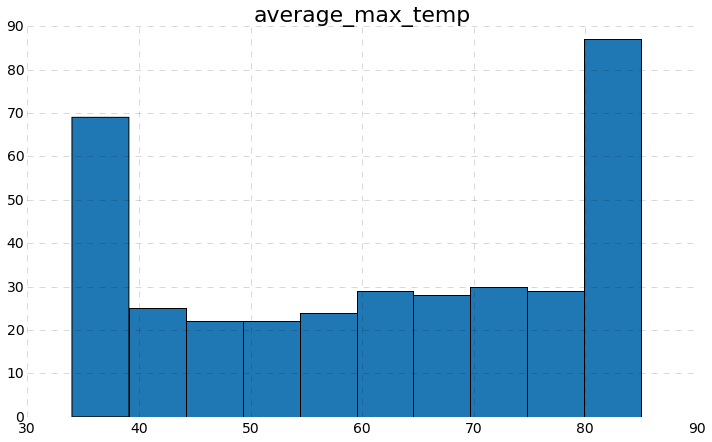

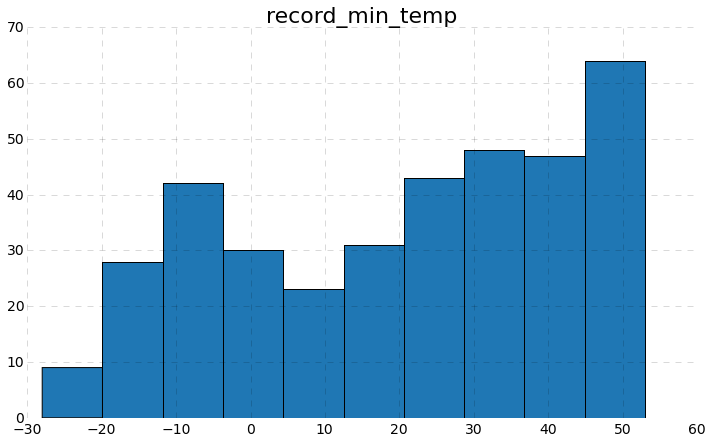

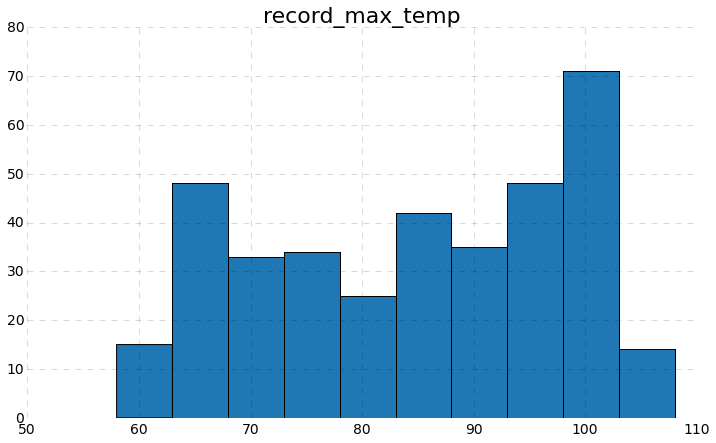

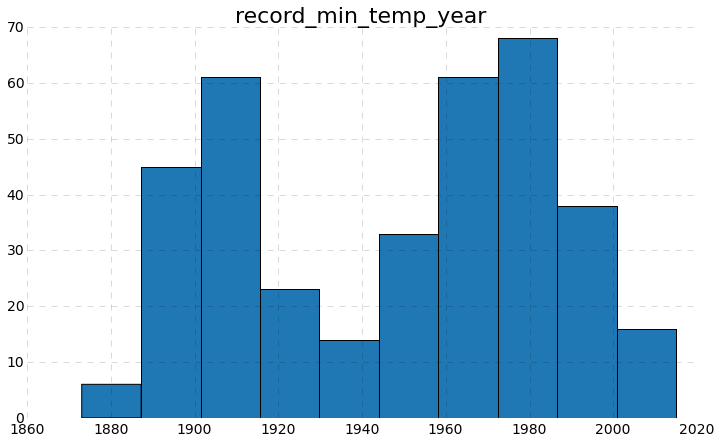

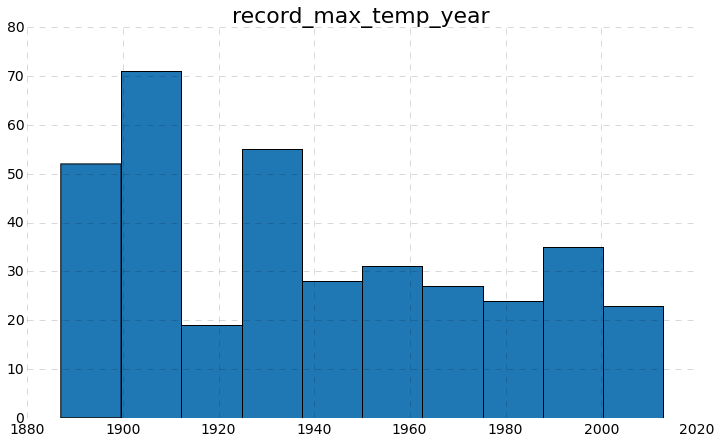

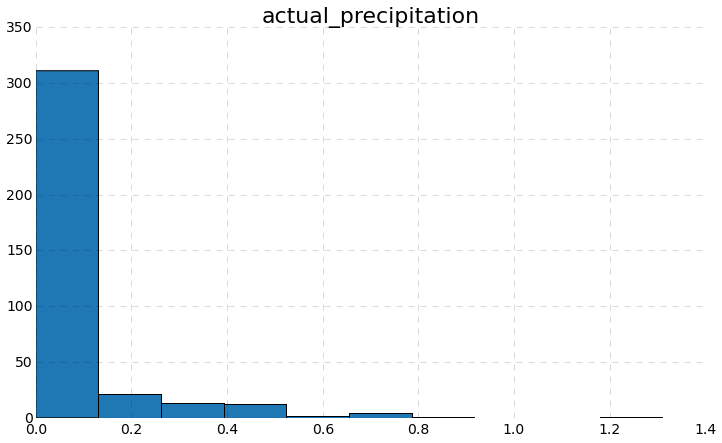

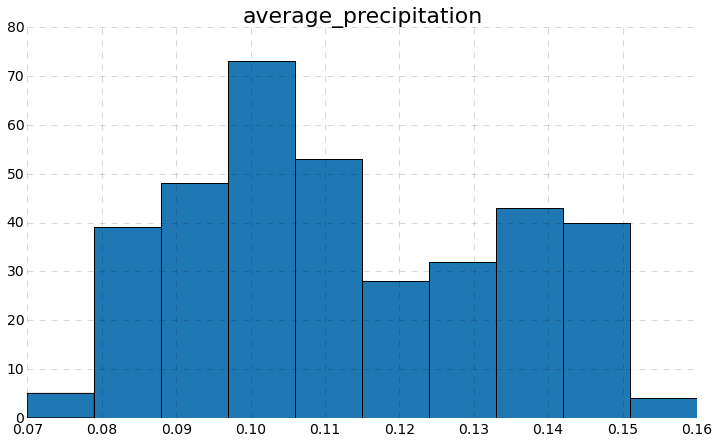

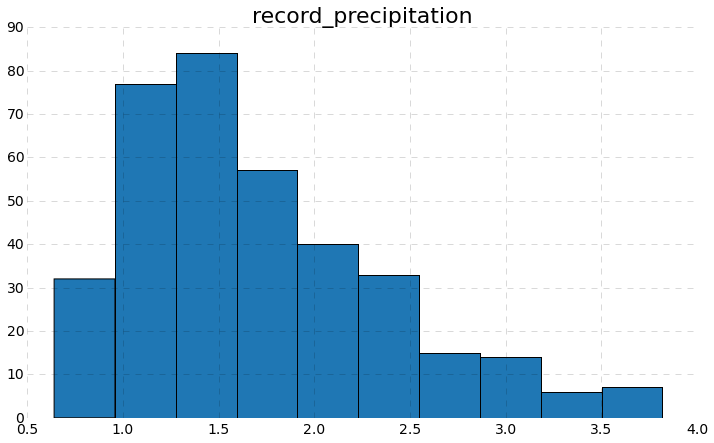

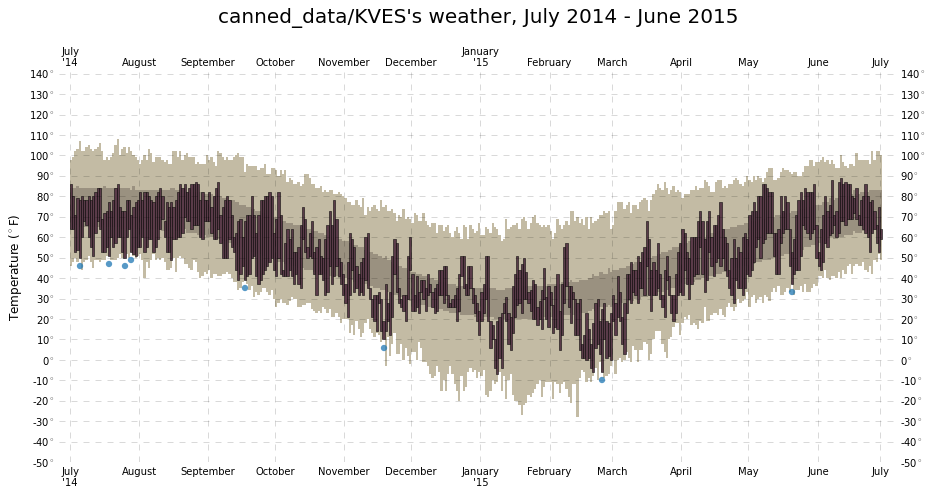

In [6]:
visualize_station('canned_data/KVES')

# KIND: Indianapolis

       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count        365.000000       365.000000       365.000000        365.000000   
mean          51.391781        42.241096        60.002740         43.928767   
std           20.110749        19.796685        20.853163         16.016831   
min            2.000000        -7.000000         9.000000         20.000000   
25%           35.000000        27.000000        42.000000         29.000000   
50%           54.000000        44.000000        64.000000         44.000000   
75%           70.000000        60.000000        79.000000         60.000000   
max           81.000000        73.000000        93.000000         66.000000   

       average_max_temp  record_min_temp  record_max_temp  \
count        365.000000       365.000000       365.000000   
mean          62.512329        20.191781        84.252055   
std           17.747093        23.406499        12.880560   
min           35.000000       -27.000000    

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


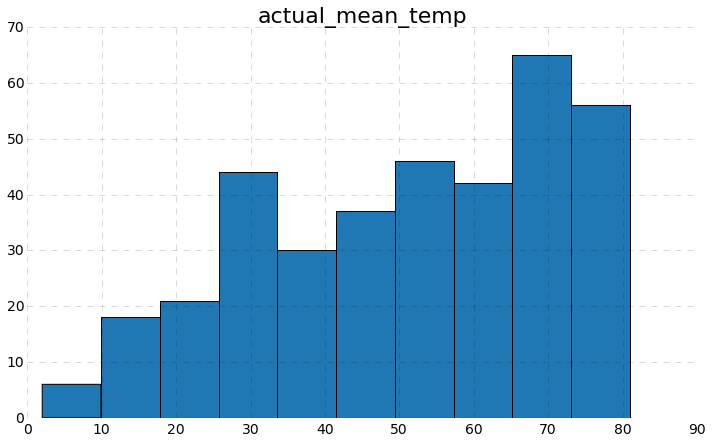

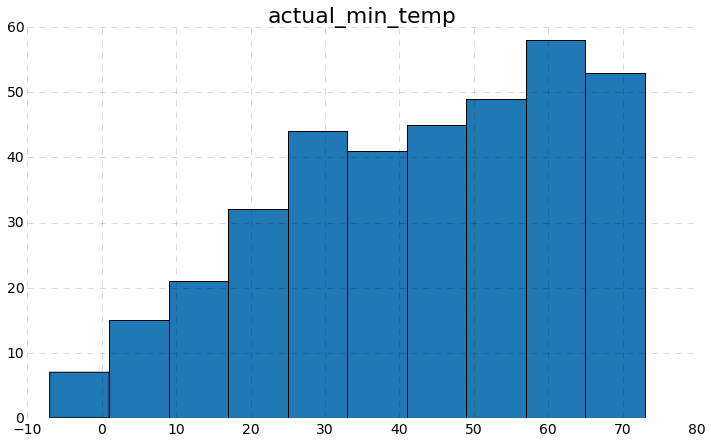

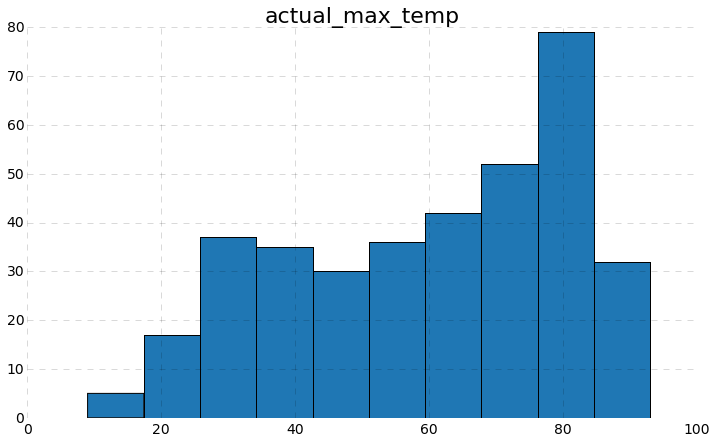

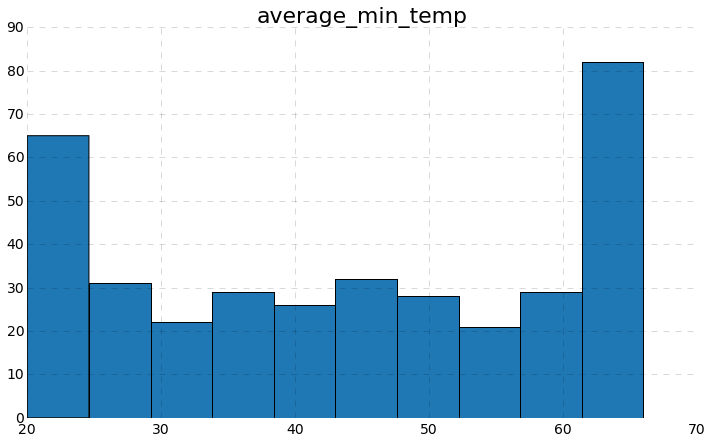

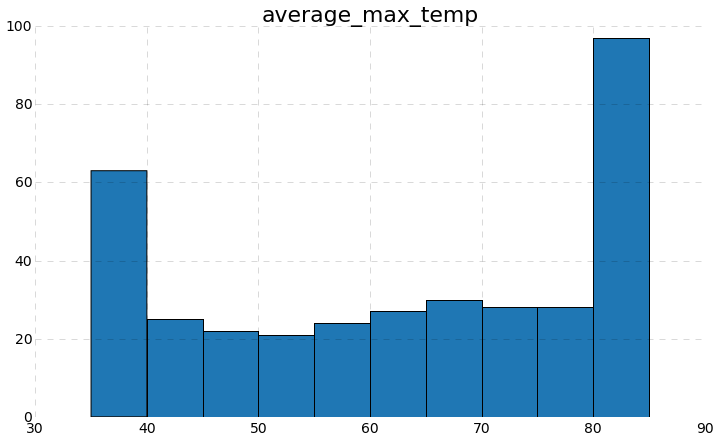

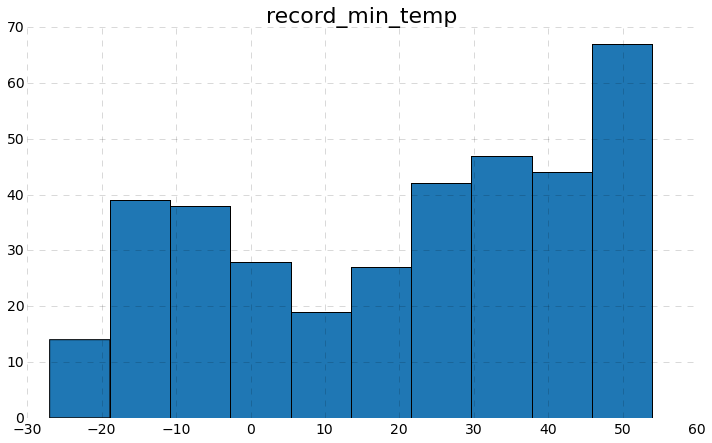

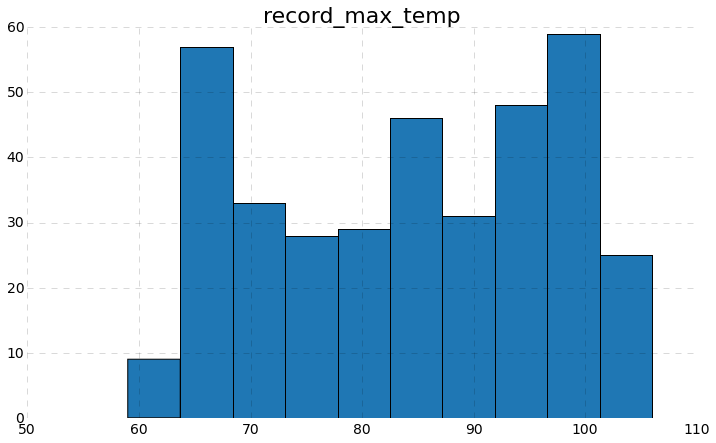

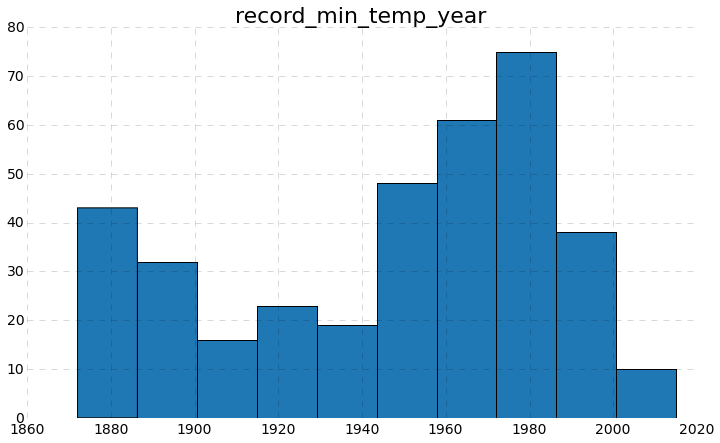

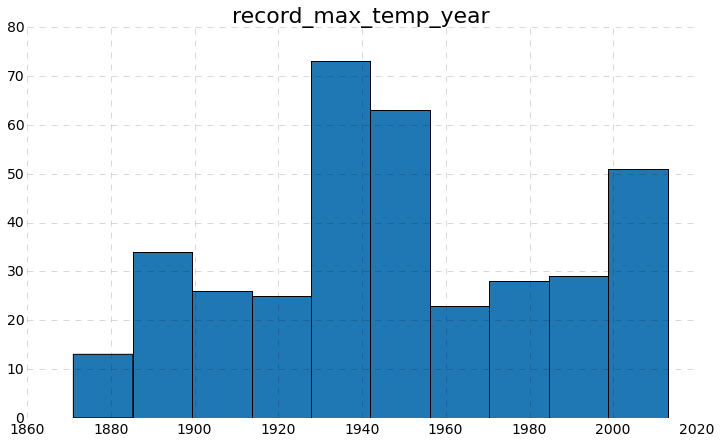

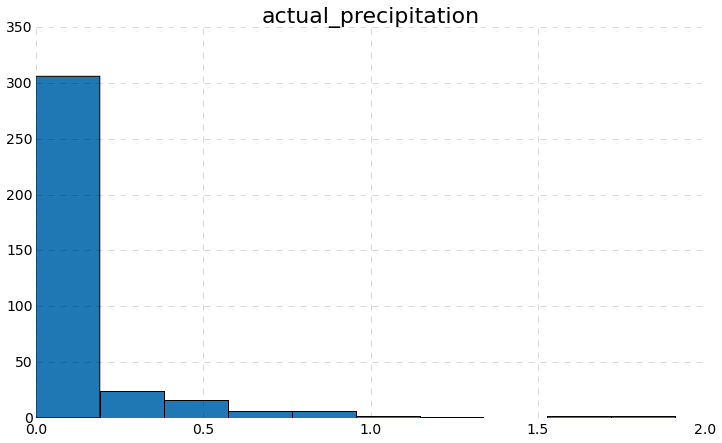

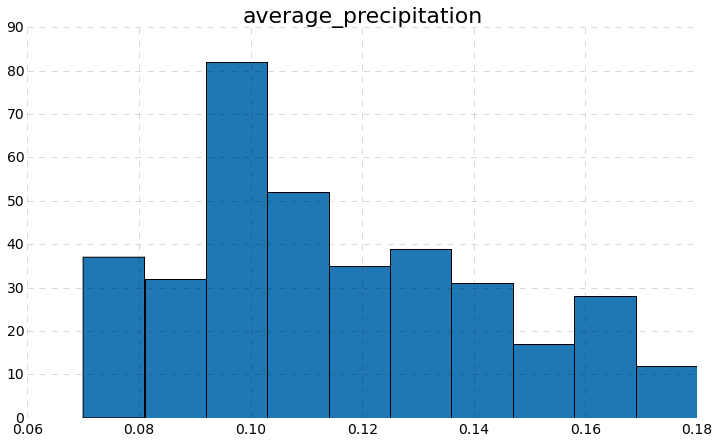

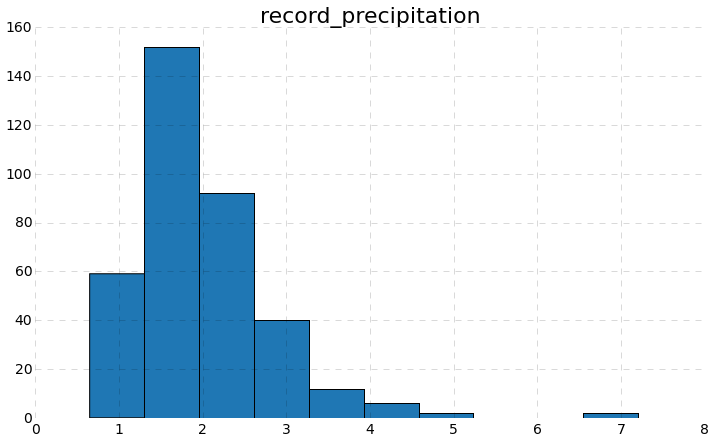

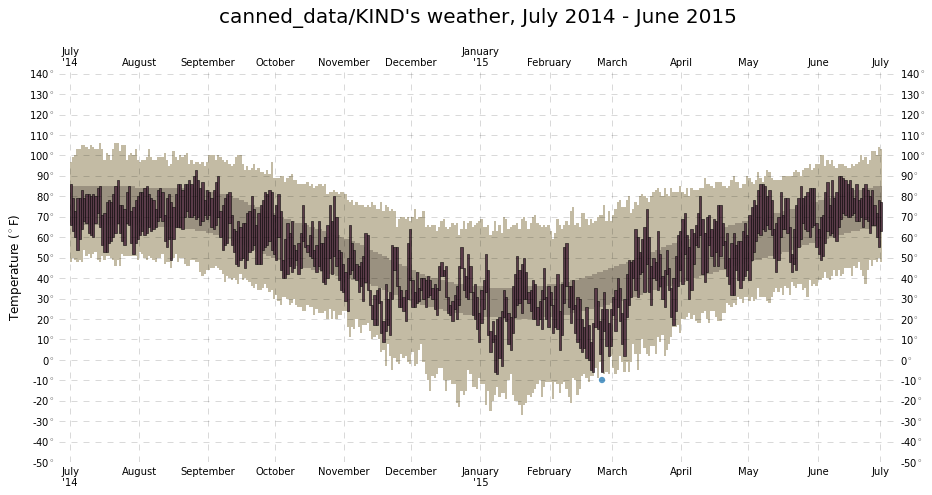

In [7]:
visualize_station('canned_data/KIND')

# KLWC: Lawrence, Kansas

       Unnamed: 0  actual_mean_temp  actual_min_temp  actual_max_temp  \
count  365.000000        365.000000       365.000000       365.000000   
mean   182.000000         54.676712        42.638356        66.252055   
std    105.510663         20.027169        20.255257        20.869480   
min      0.000000          9.000000        -3.000000        19.000000   
25%     91.000000         39.000000        27.000000        50.000000   
50%    182.000000         57.000000        44.000000        70.000000   
75%    273.000000         71.000000        60.000000        83.000000   
max    364.000000         91.000000        80.000000       104.000000   

       average_min_temp  average_max_temp  record_min_temp  record_max_temp  \
count        365.000000        365.000000       365.000000       365.000000   
mean          43.342466         66.473973        25.350685        85.068493   
std           17.144361         17.787590        21.988953        14.581081   
min           18.000000   

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


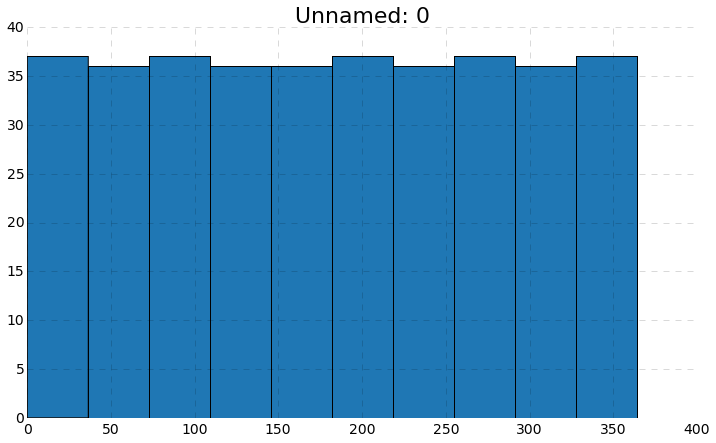

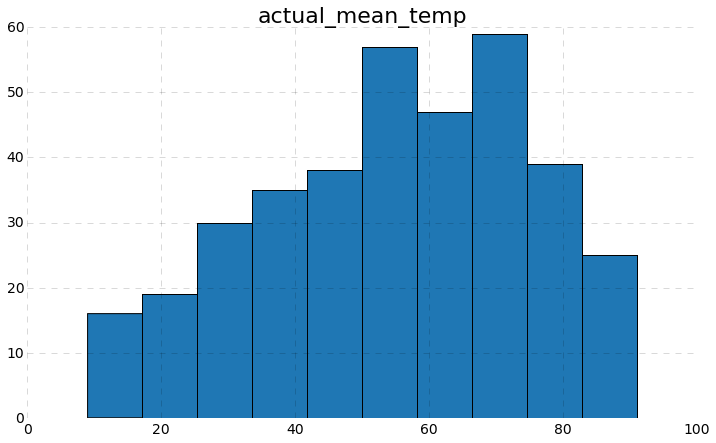

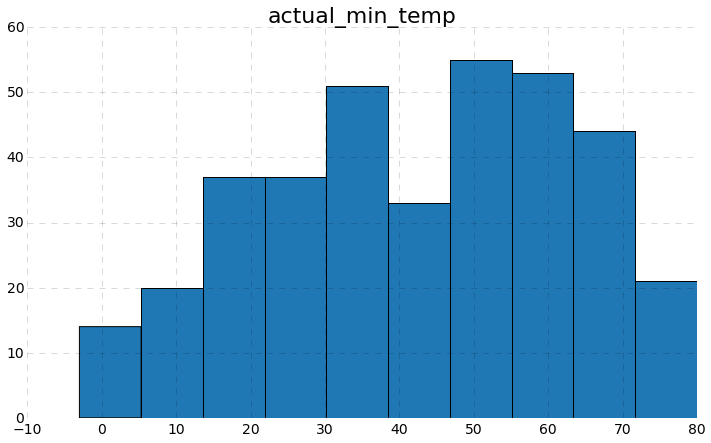

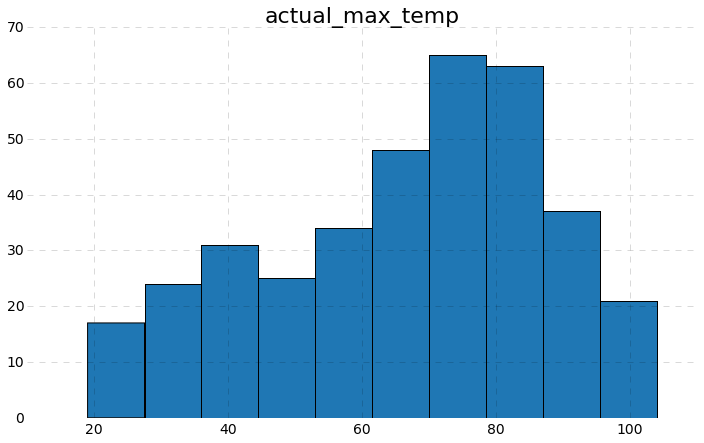

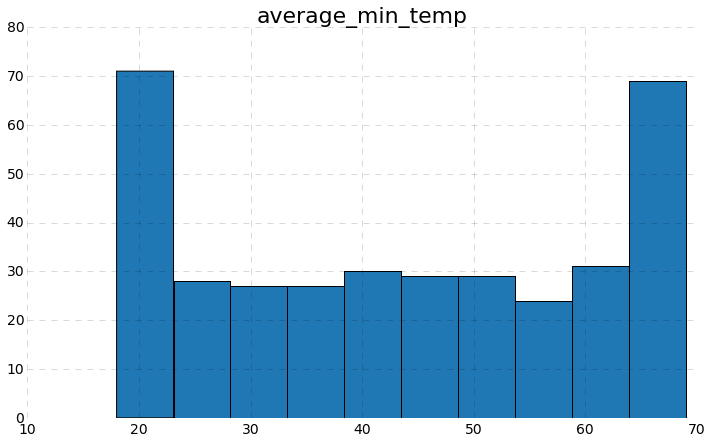

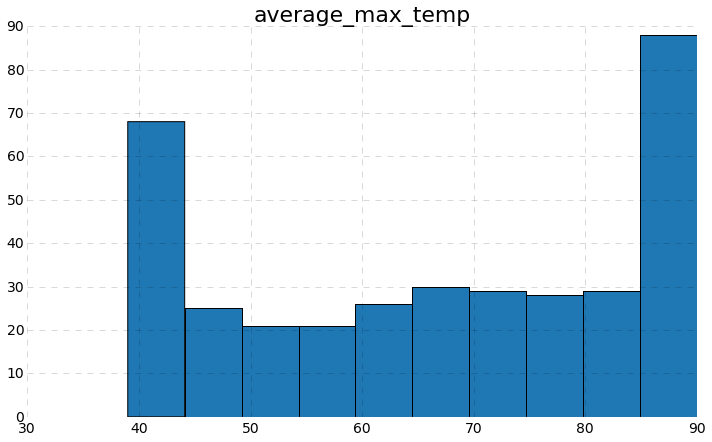

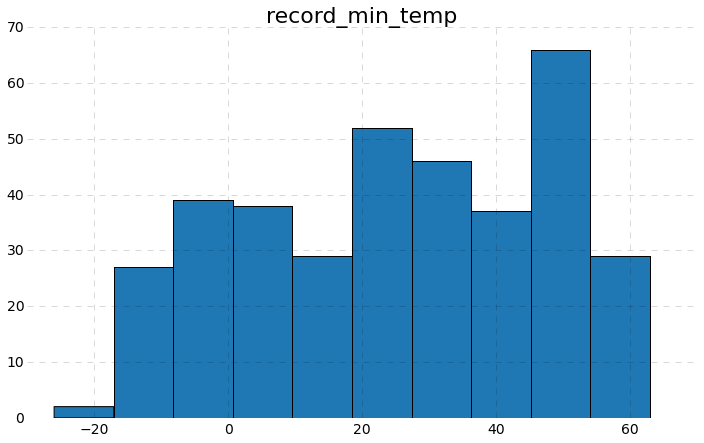

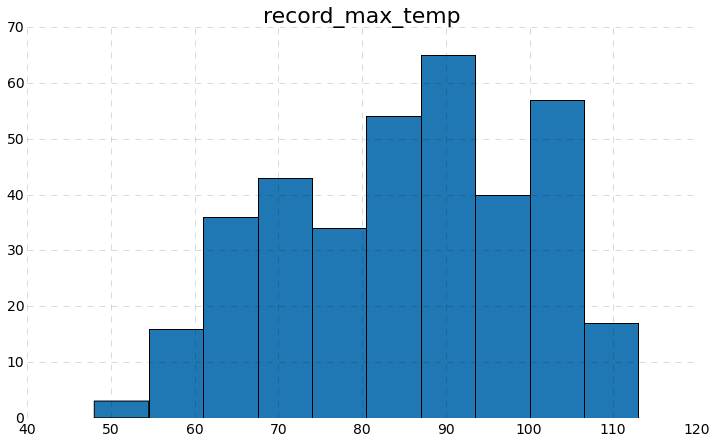

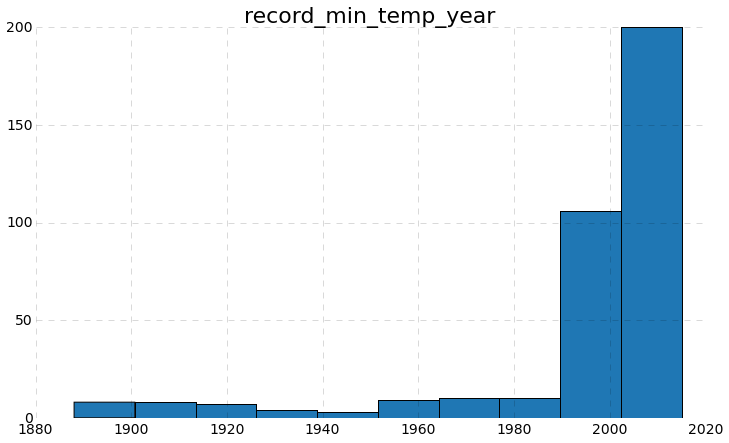

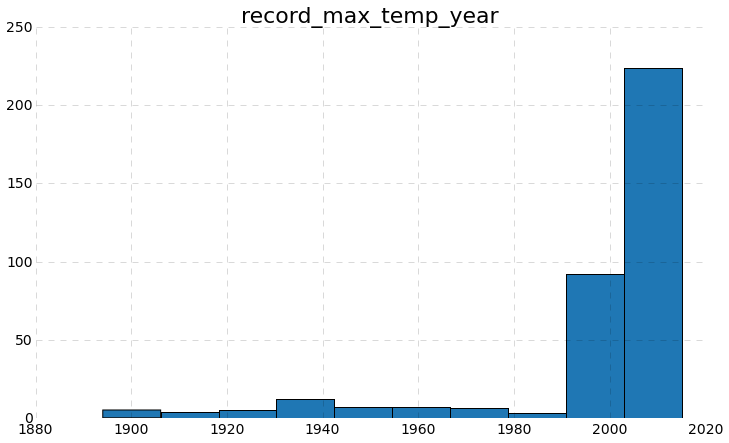

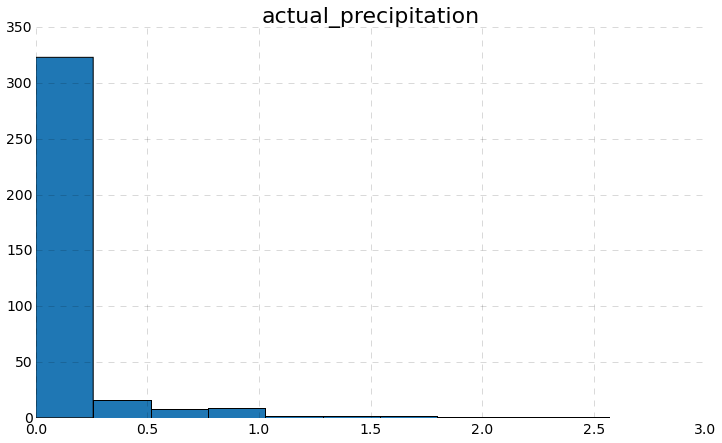

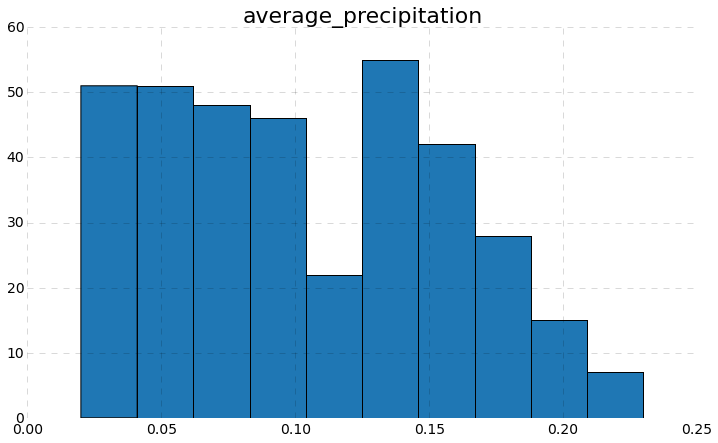

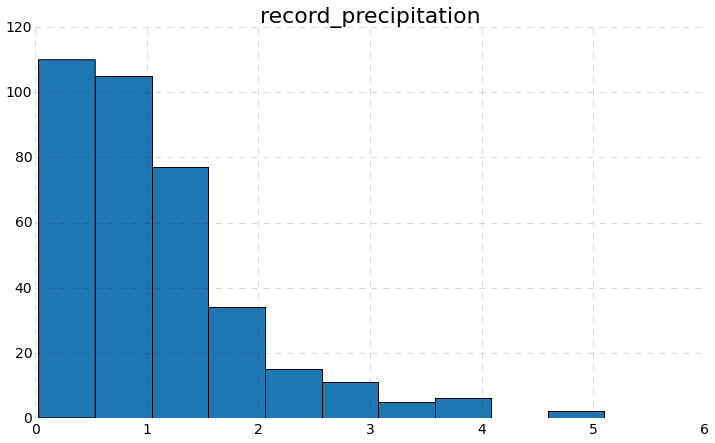

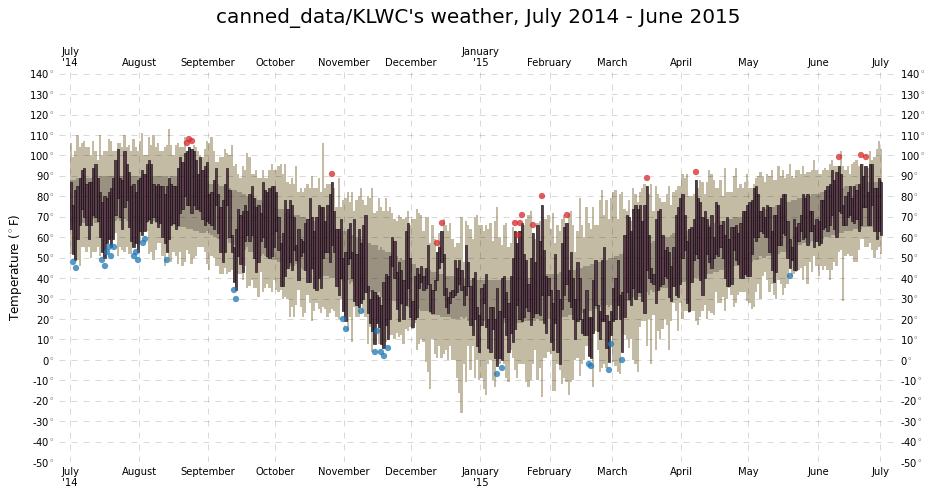

In [8]:
visualize_station('canned_data/KLWC')

# KMDW: Chicago Midway

       Unnamed: 0  actual_mean_temp  actual_min_temp  actual_max_temp  \
count  365.000000        365.000000       365.000000       365.000000   
mean   182.000000         51.032877        42.857534        58.709589   
std    105.510663         20.353713        19.746650        21.425389   
min      0.000000          1.000000        -7.000000         7.000000   
25%     91.000000         35.000000        30.000000        39.000000   
50%    182.000000         53.000000        44.000000        62.000000   
75%    273.000000         70.000000        60.000000        79.000000   
max    364.000000         83.000000        74.000000        94.000000   

       average_min_temp  average_max_temp  record_min_temp  record_max_temp  \
count        365.000000        365.000000       365.000000       365.000000   
mean          43.517808         59.463014        21.284932        83.079452   
std           17.300760         18.803842        23.140301        15.674461   
min           18.000000   

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


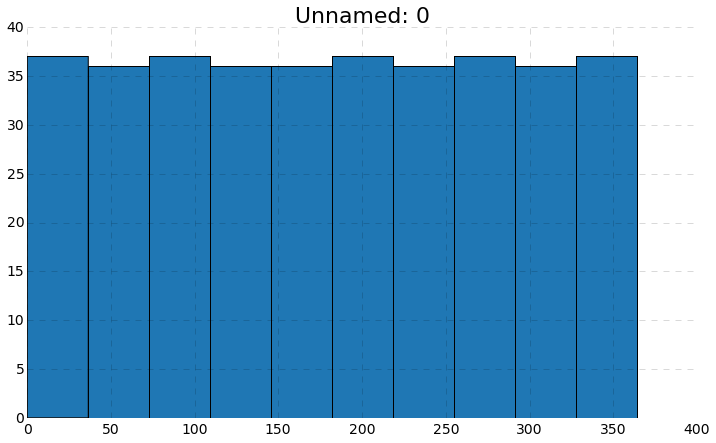

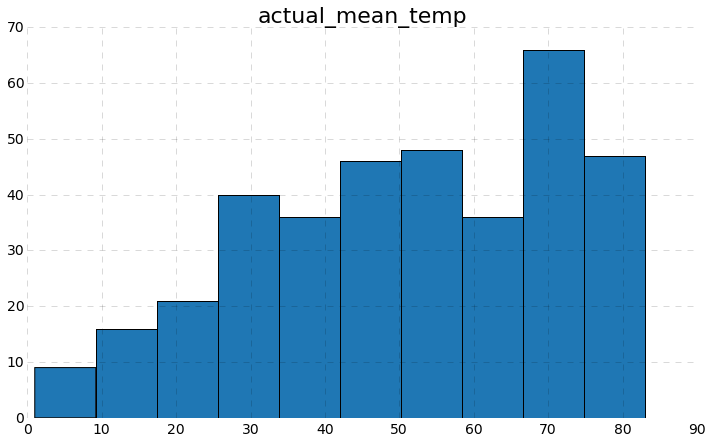

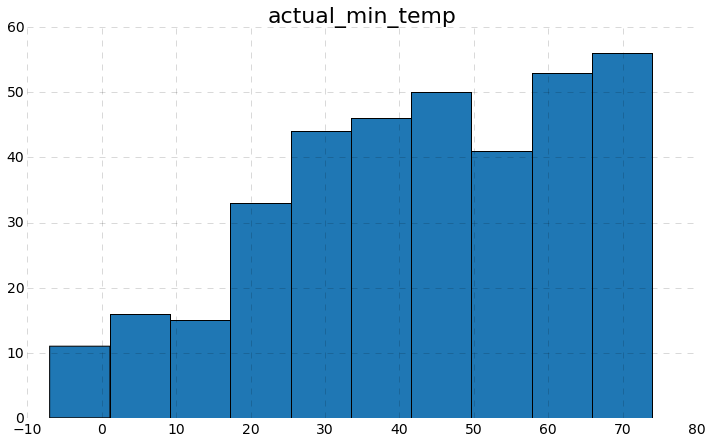

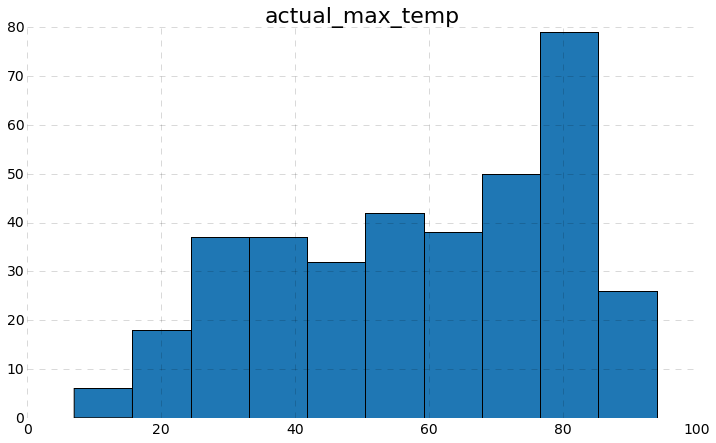

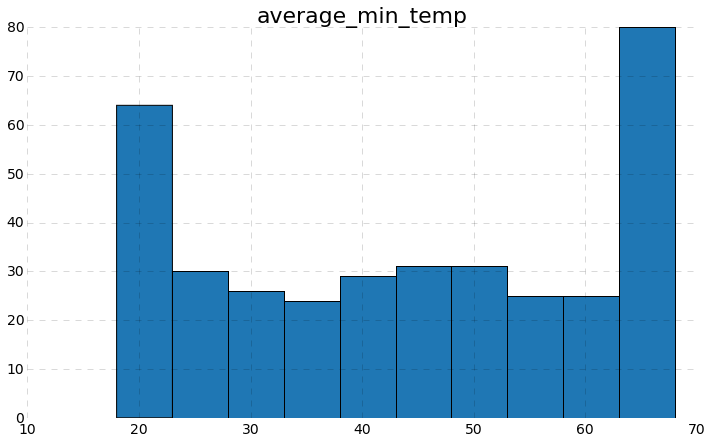

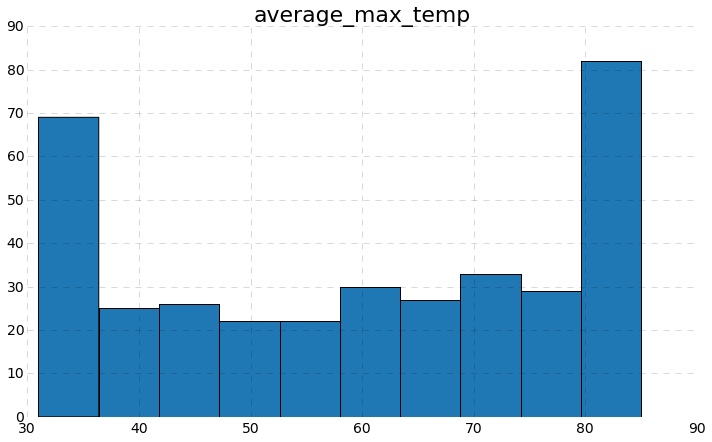

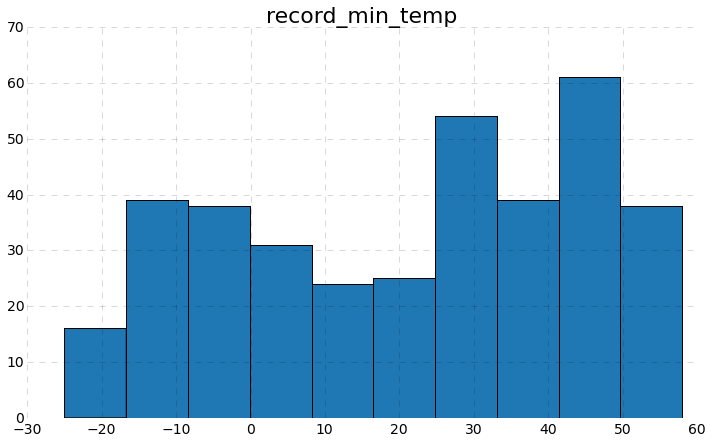

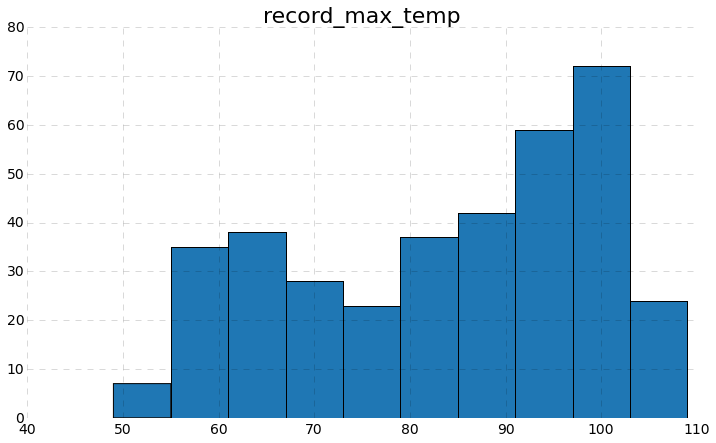

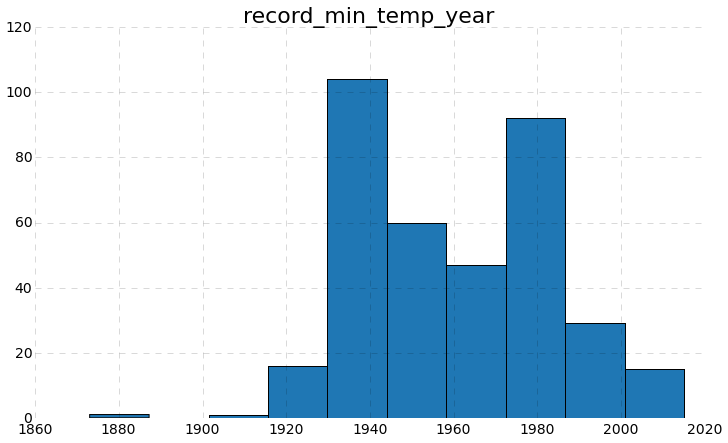

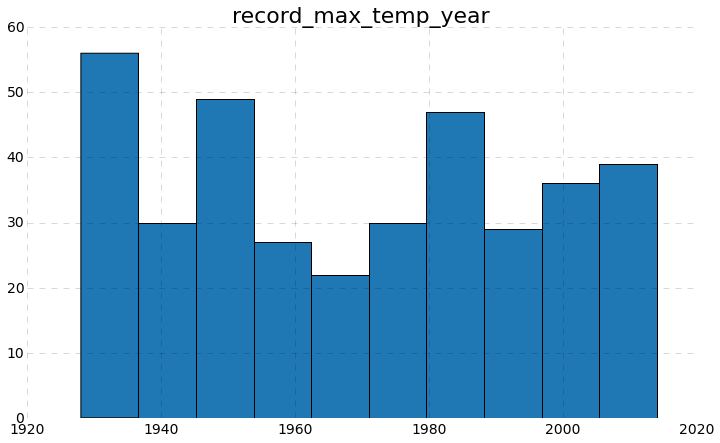

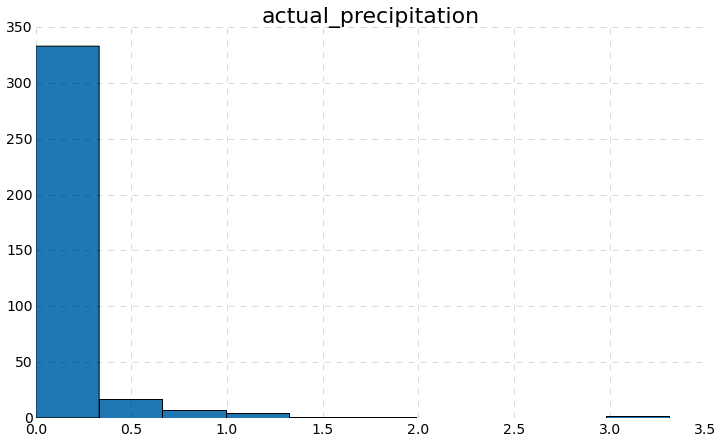

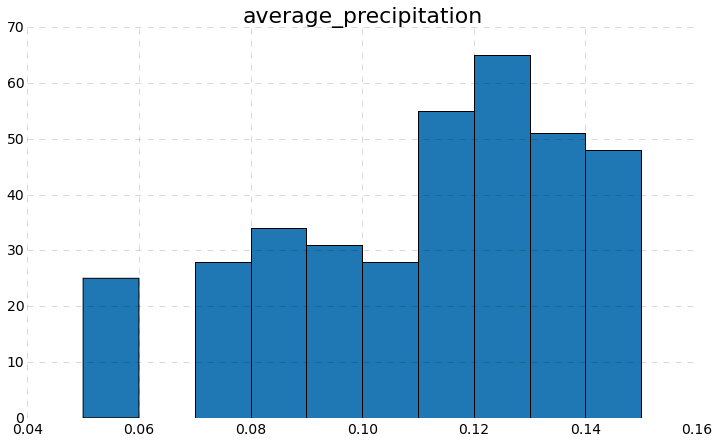

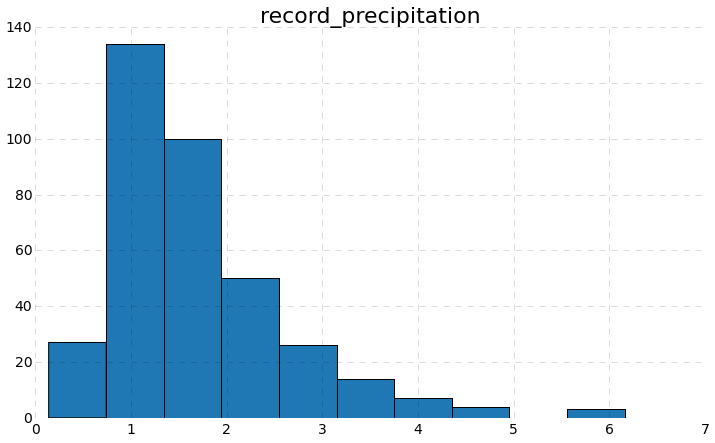

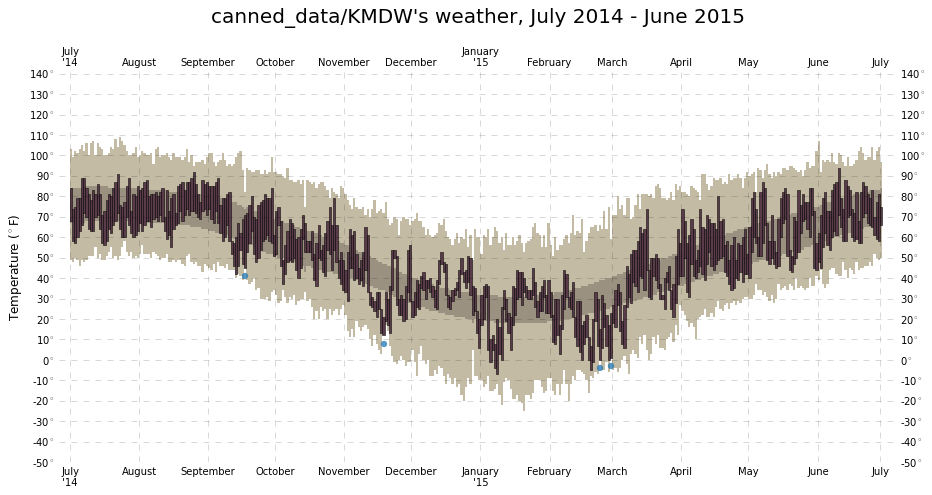

In [9]:
visualize_station('canned_data/KMDW')

# KMIE Muncie, Indiana

       Unnamed: 0  actual_mean_temp  actual_min_temp  actual_max_temp  \
count  365.000000        365.000000       365.000000       365.000000   
mean   182.000000         50.326027        41.043836        59.139726   
std    105.510663         20.129130        19.548847        21.230154   
min      0.000000          1.000000        -8.000000         6.000000   
25%     91.000000         34.000000        27.000000        41.000000   
50%    182.000000         53.000000        43.000000        62.000000   
75%    273.000000         69.000000        58.000000        79.000000   
max    364.000000         80.000000        73.000000        90.000000   

       average_min_temp  average_max_temp  record_min_temp  record_max_temp  \
count        365.000000        365.000000       365.000000       365.000000   
mean          42.495890         61.394521        20.843836        80.857534   
std           16.070863         18.165085        23.101550        13.514399   
min           19.000000   

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


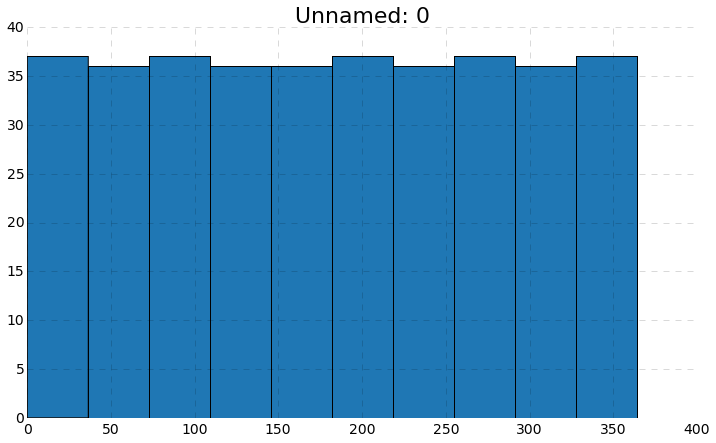

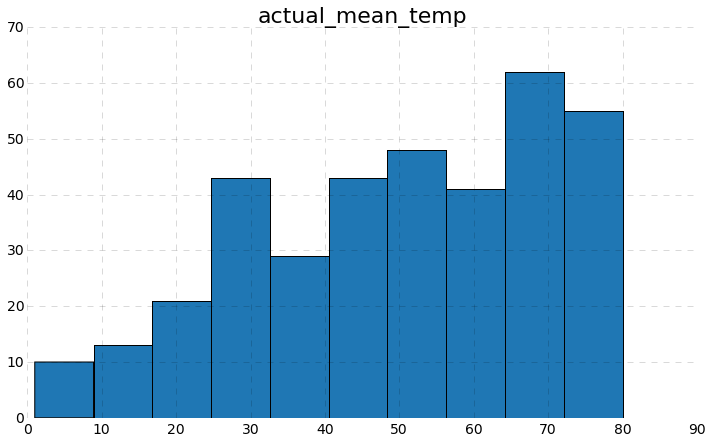

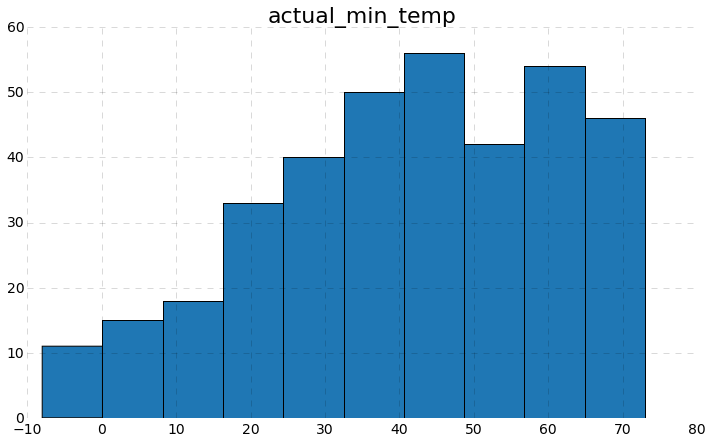

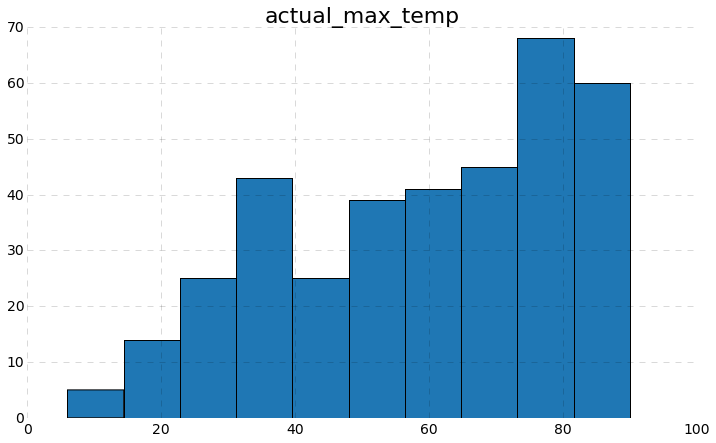

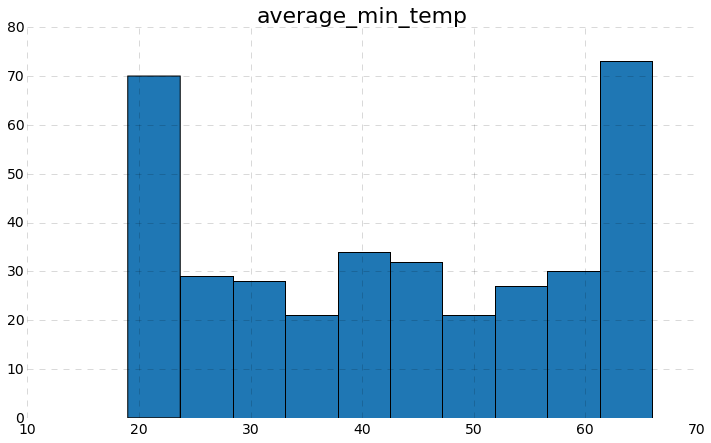

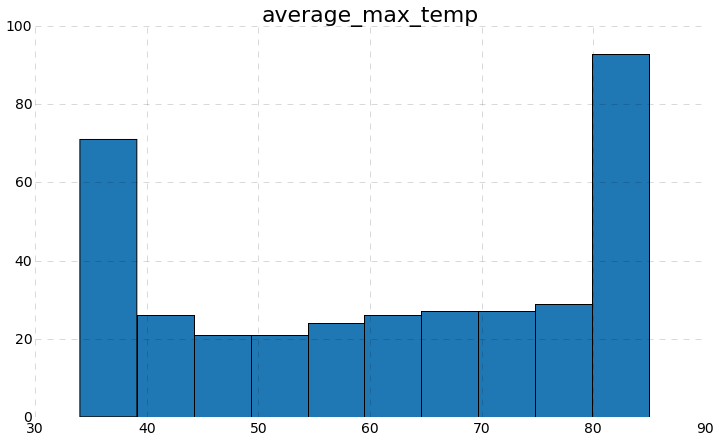

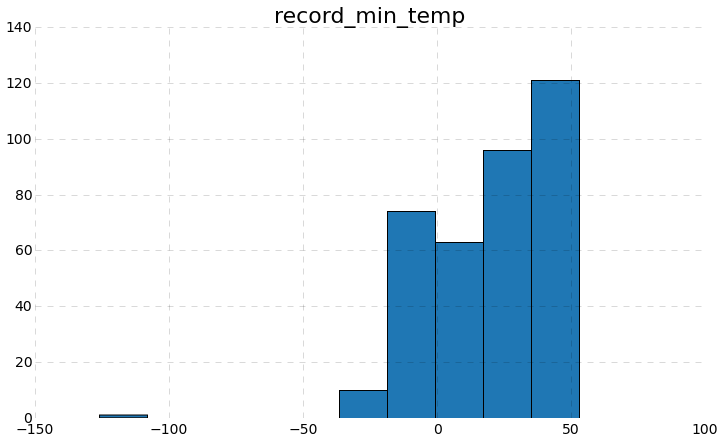

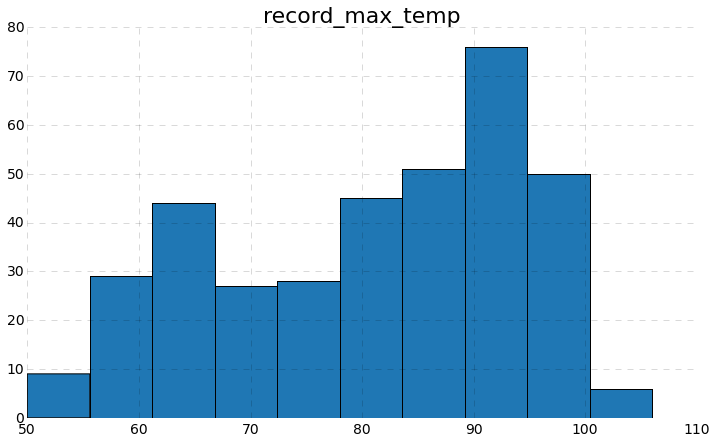

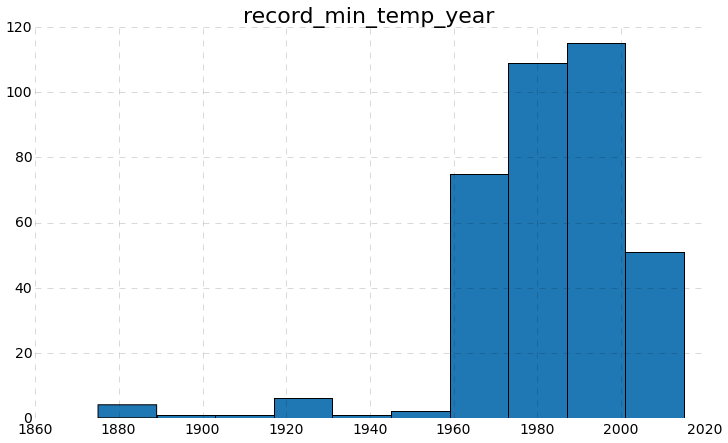

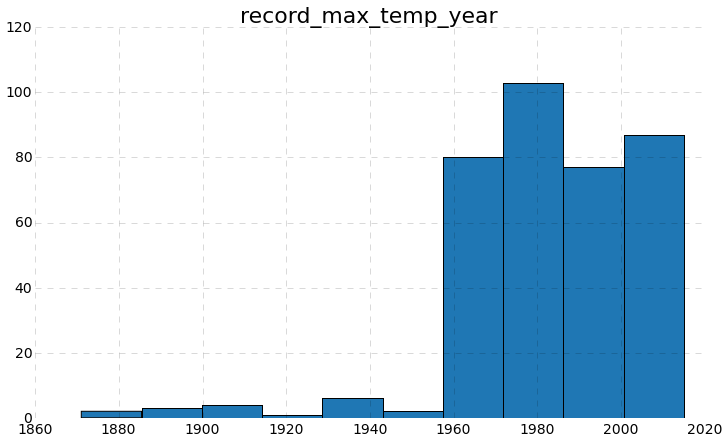

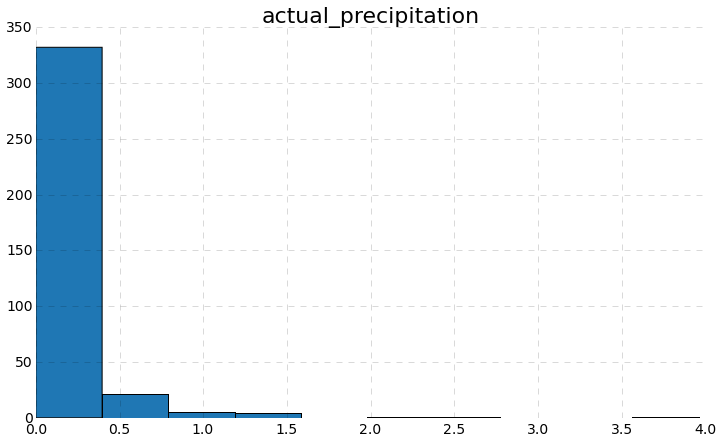

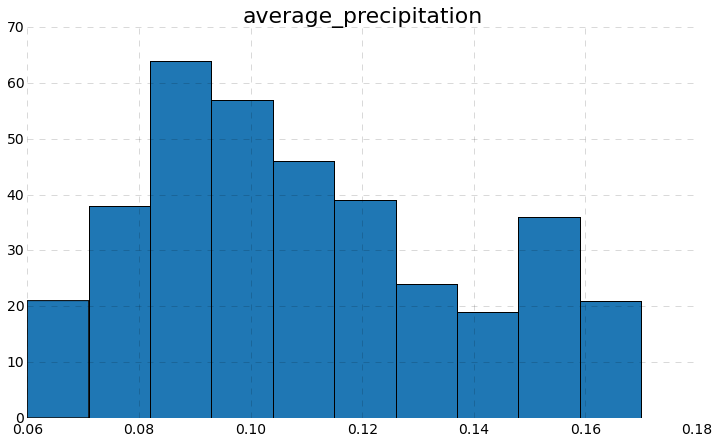

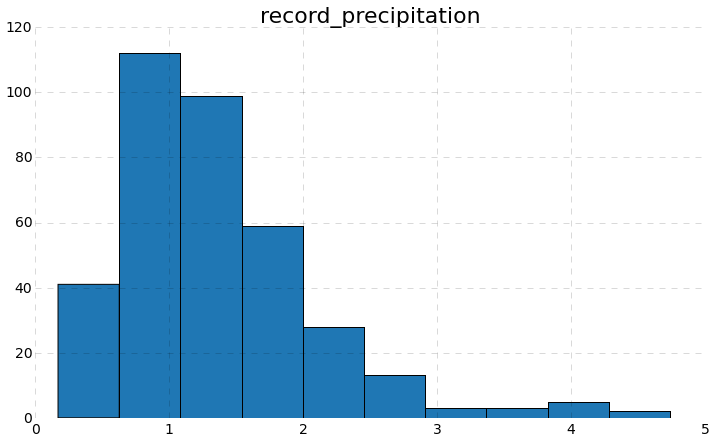

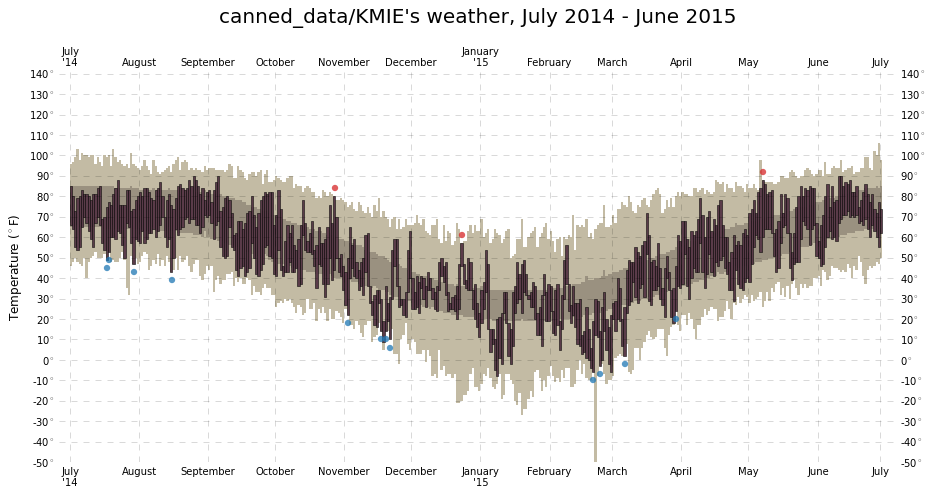

In [10]:
visualize_station('canned_data/KMIE')

# KNYC Central Park, New York

       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count        365.000000       365.000000       365.000000        365.000000   
mean          54.736986        47.246575        61.734247         48.016438   
std           18.679979        18.277156        19.446971         14.749176   
min           11.000000         2.000000        19.000000         27.000000   
25%           39.000000        34.000000        44.000000         34.000000   
50%           58.000000        50.000000        65.000000         48.000000   
75%           72.000000        64.000000        80.000000         63.000000   
max           85.000000        77.000000        92.000000         69.000000   

       average_max_temp  record_min_temp  record_max_temp  \
count        365.000000       365.000000       365.000000   
mean          62.079452        28.243836        83.742466   
std           16.068765        20.729107        13.360573   
min           38.000000       -15.000000    

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


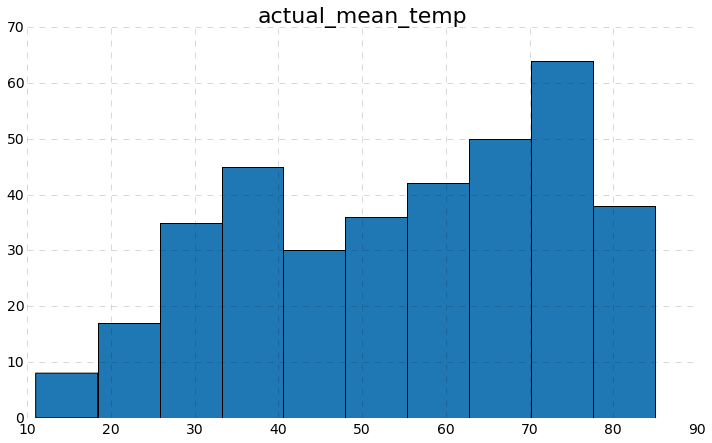

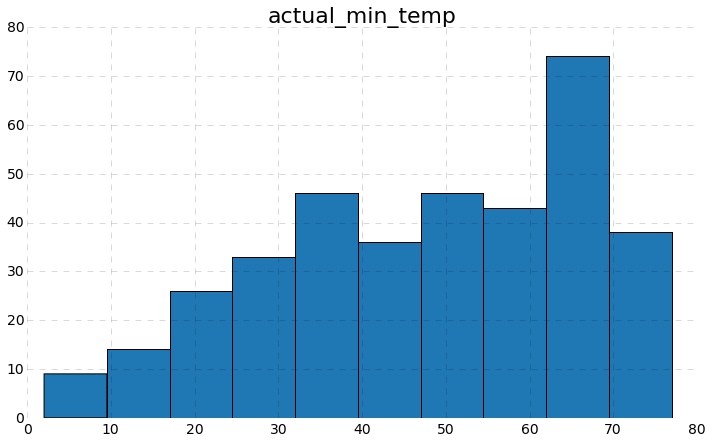

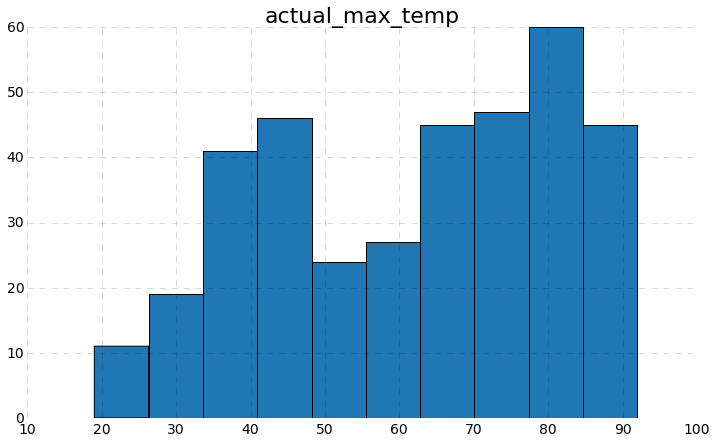

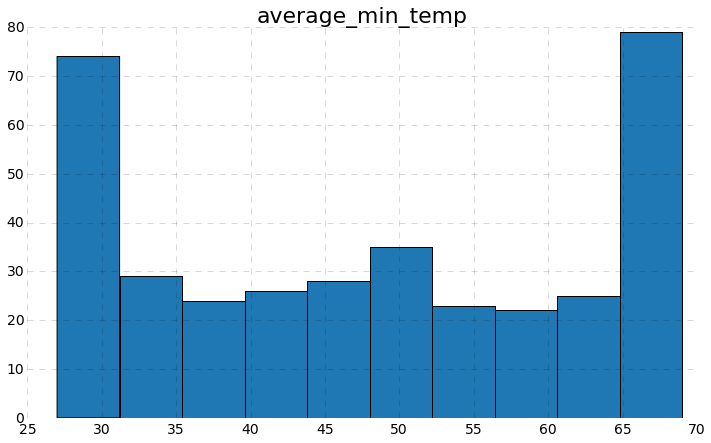

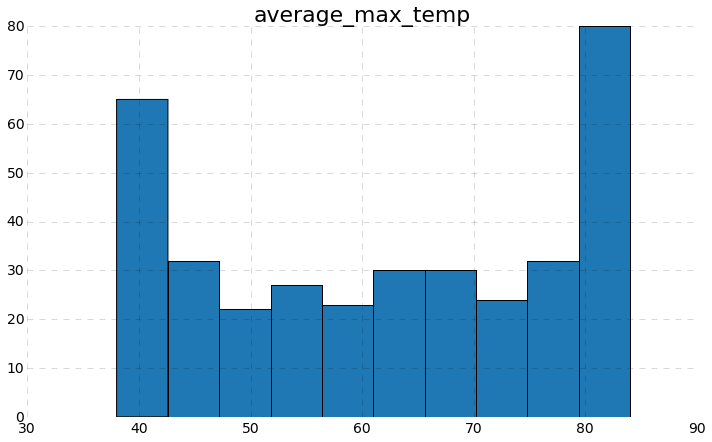

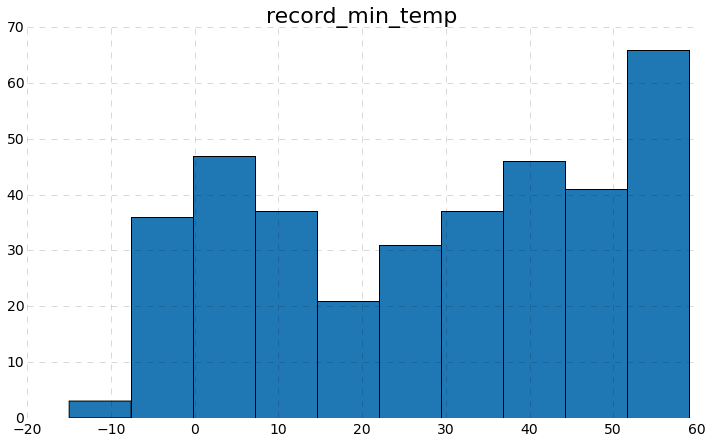

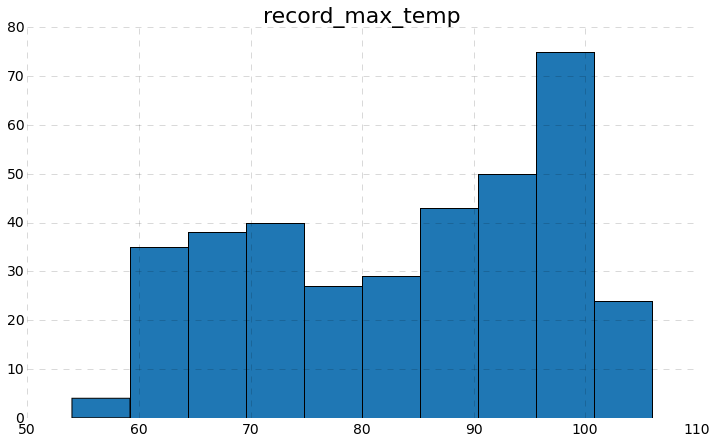

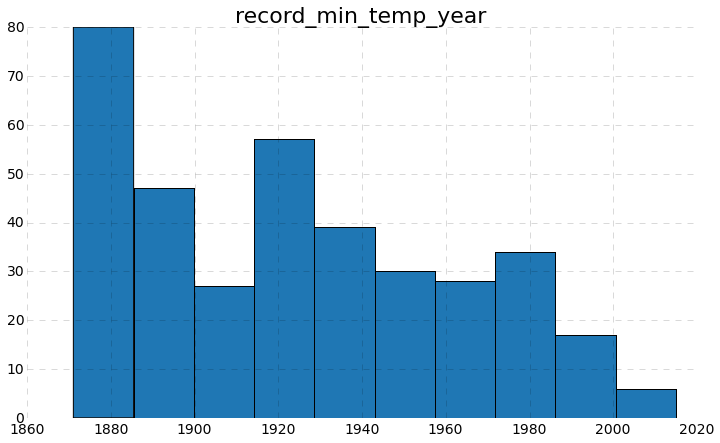

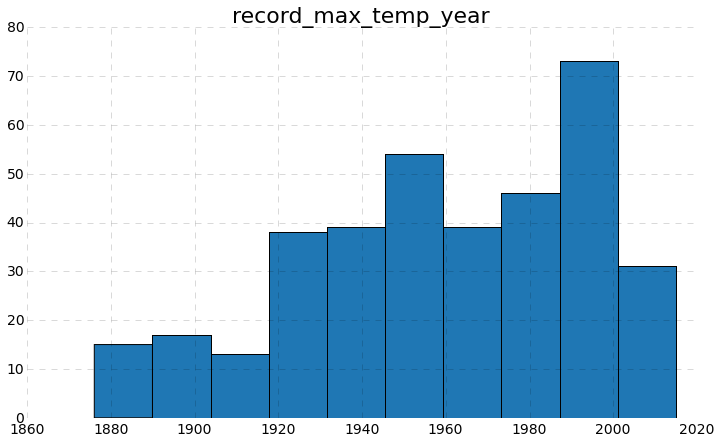

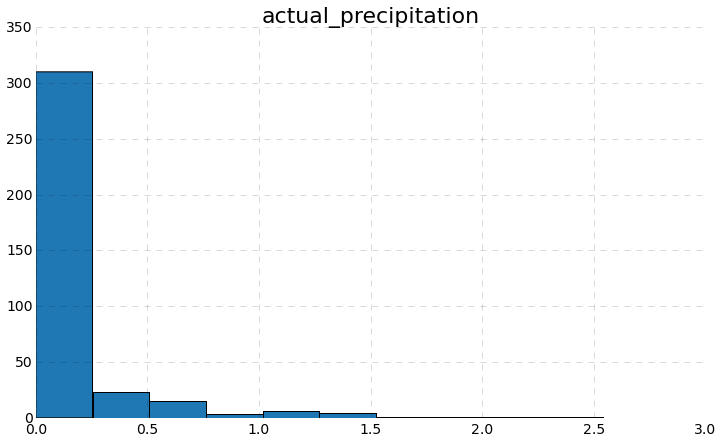

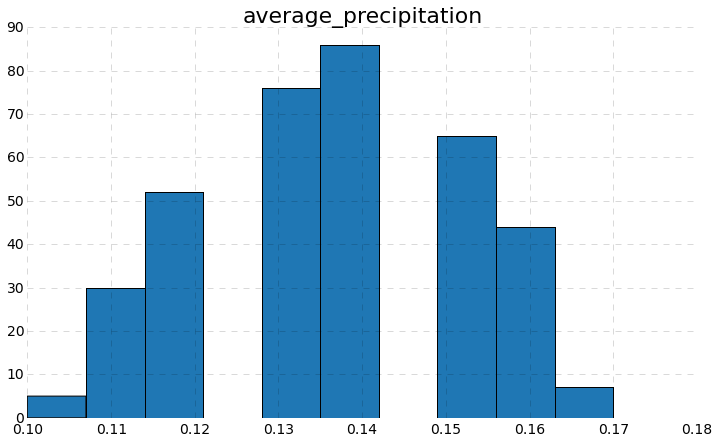

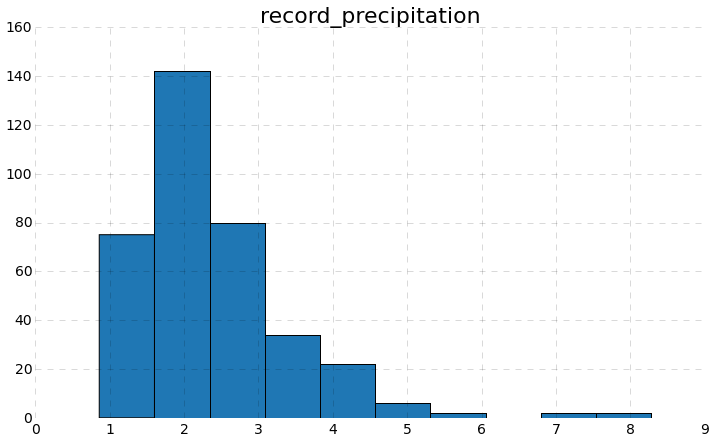

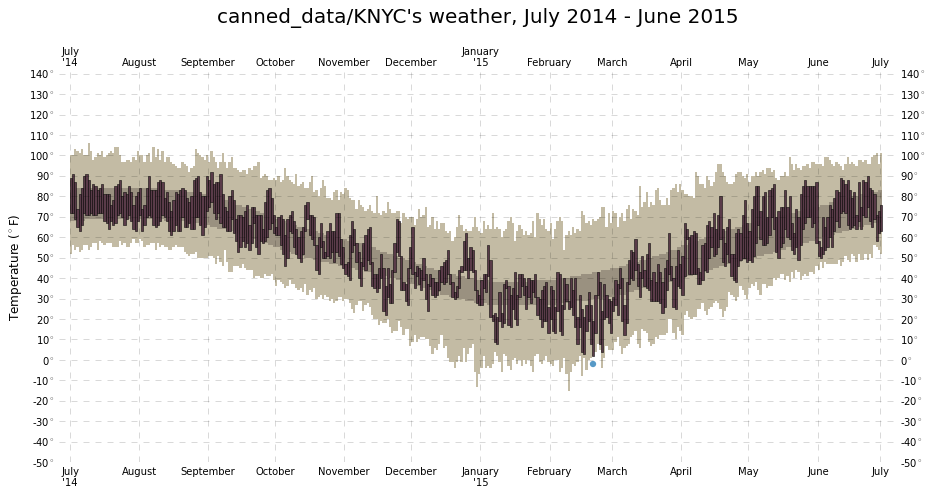

In [11]:
visualize_station('canned_data/KNYC')

# KPWK Chicago Executive, Illinois

       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count        365.000000       365.000000       365.000000        365.000000   
mean          47.060274        38.375342        55.282192         39.353425   
std           22.079071        20.834617        23.891003         18.094487   
min            0.000000       -12.000000         0.000000          0.000000   
25%           30.000000        24.000000        35.000000         24.000000   
50%           50.000000        40.000000        59.000000         40.000000   
75%           66.000000        56.000000        77.000000         56.000000   
max           81.000000        73.000000        92.000000         64.000000   

       average_max_temp  record_min_temp  record_max_temp  \
count        365.000000       365.000000       365.000000   
mean          56.731507        26.005479        74.178082   
std           21.802289        21.355185        22.402501   
min            0.000000       -16.000000    

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


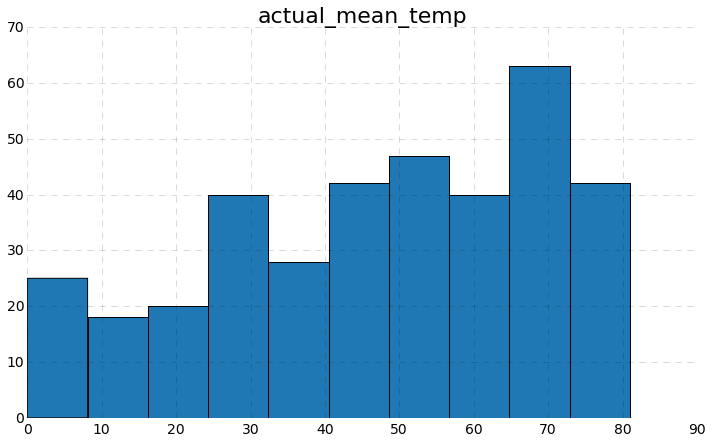

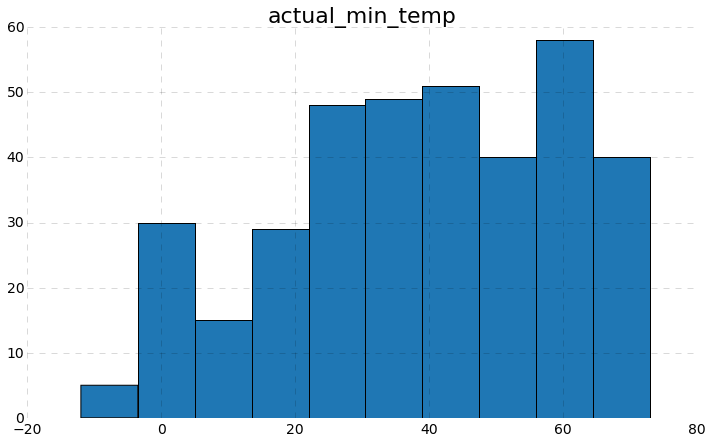

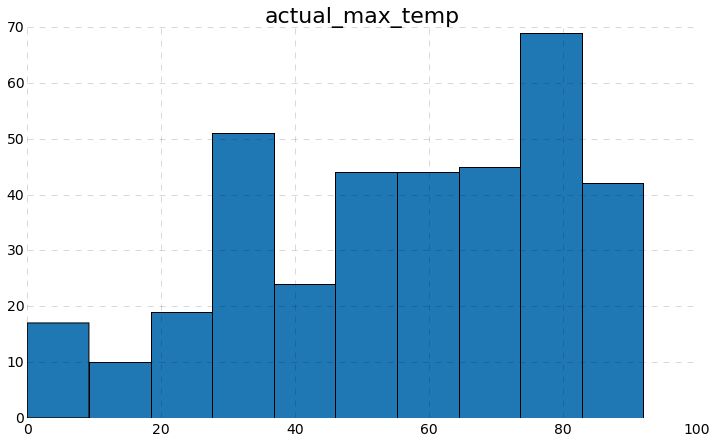

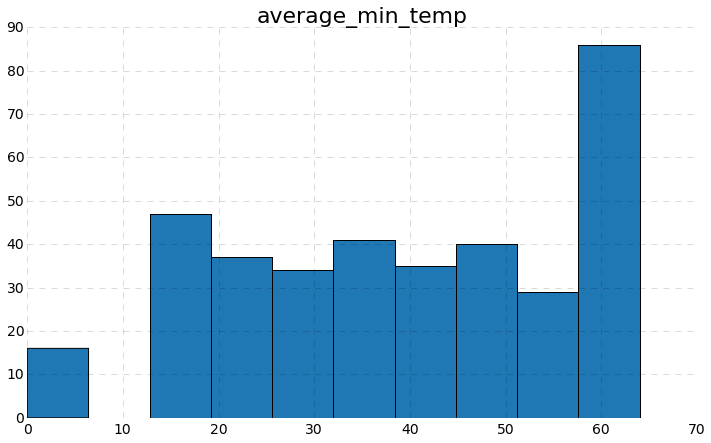

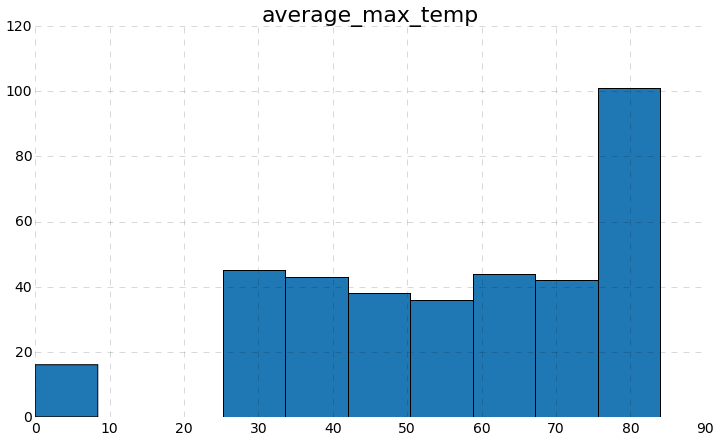

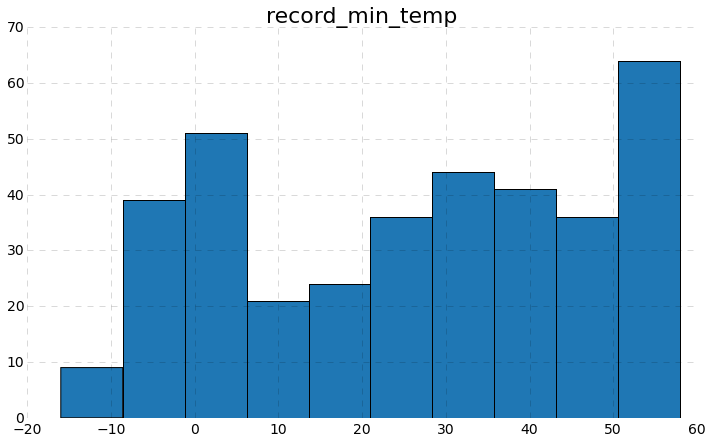

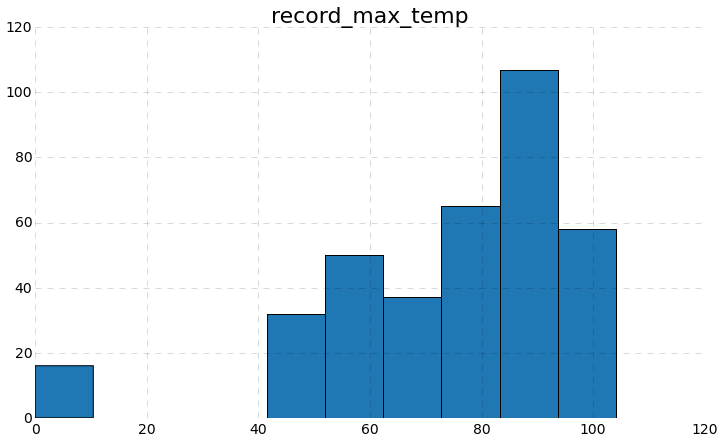

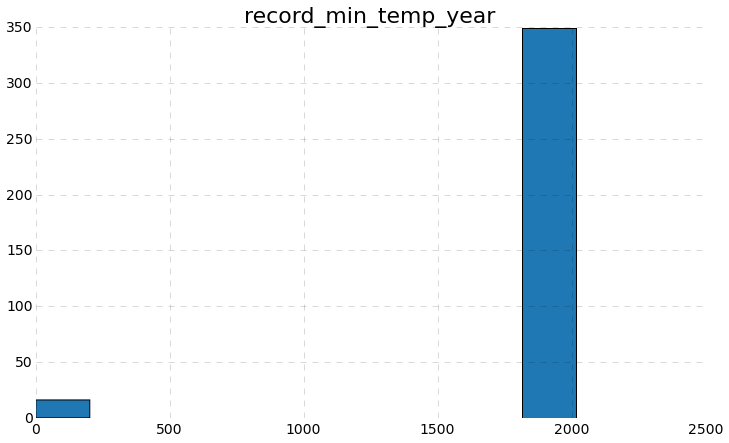

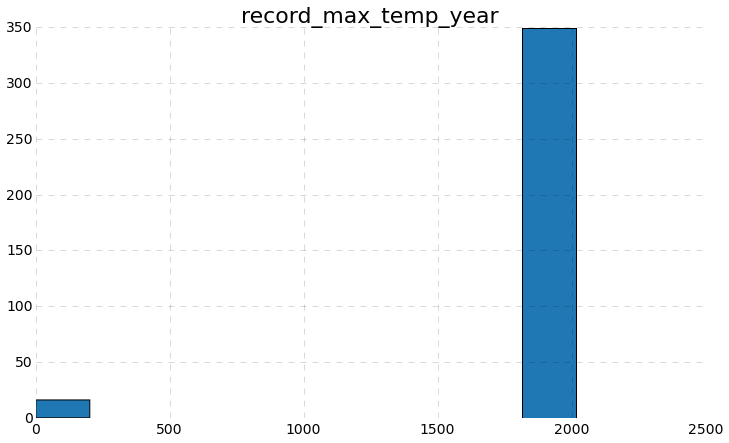

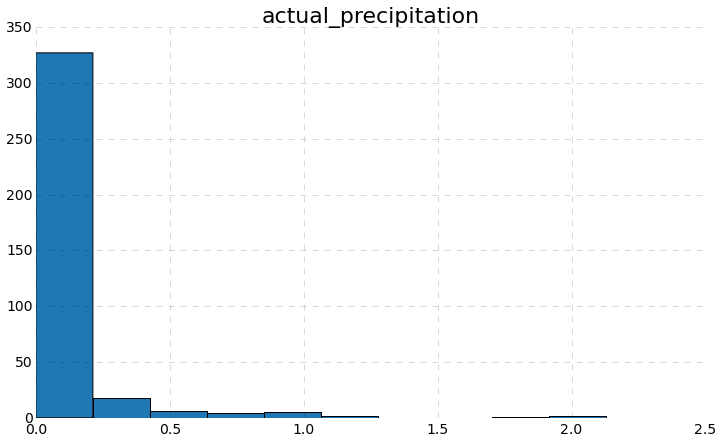

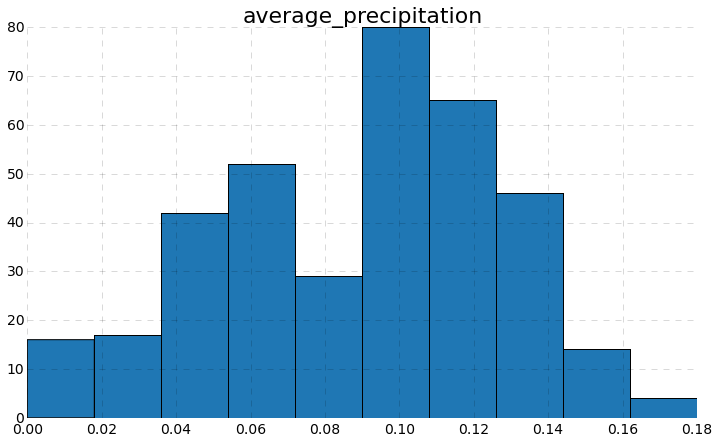

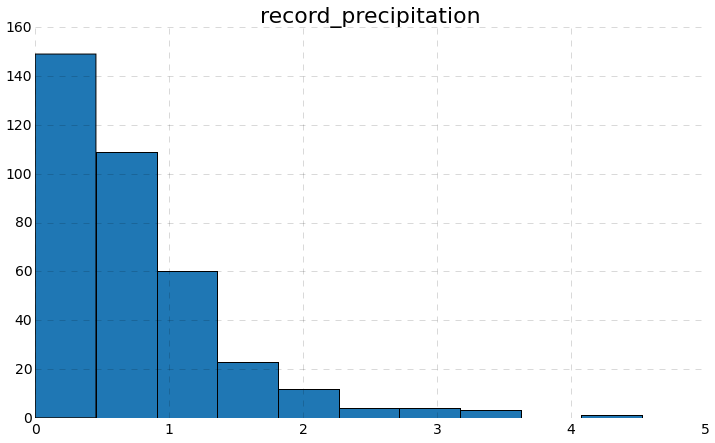

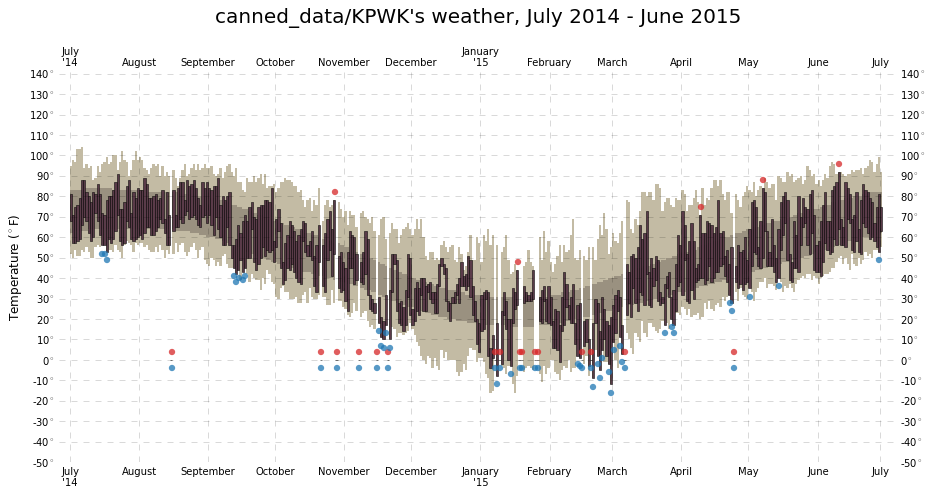

In [12]:
visualize_station('canned_data/KPWK')

# KTOP Topeka, Kansas

       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count        365.000000       365.000000       365.000000        365.000000   
mean          55.778082        44.320548        66.753425         44.243836   
std           19.940228        20.072909        20.783407         17.193573   
min           11.000000         0.000000        18.000000         19.000000   
25%           41.000000        29.000000        51.000000         28.000000   
50%           57.000000        45.000000        71.000000         44.000000   
75%           72.000000        61.000000        83.000000         61.000000   
max           91.000000        80.000000       103.000000         69.000000   

       average_max_temp  record_min_temp  record_max_temp  \
count        365.000000       365.000000       365.000000   
mean          66.156164        20.663014        89.764384   
std           17.711834        23.538462        13.978765   
min           39.000000       -26.000000    

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


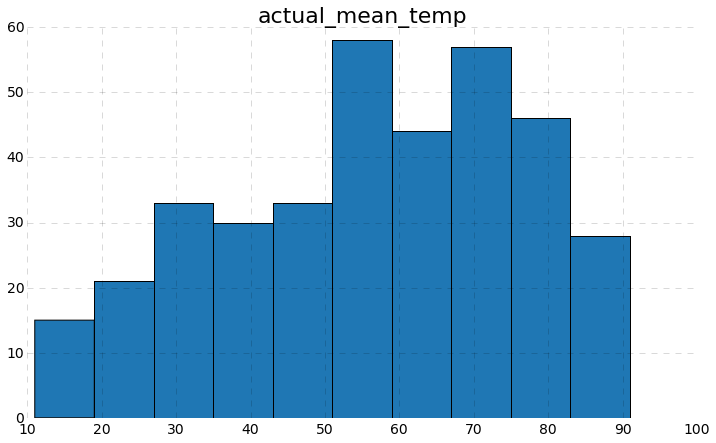

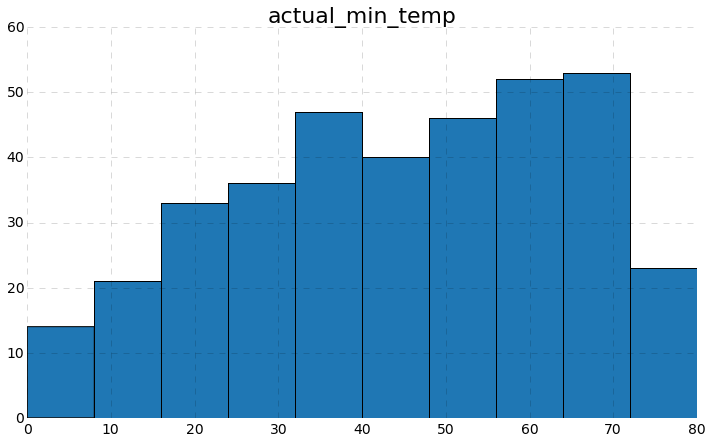

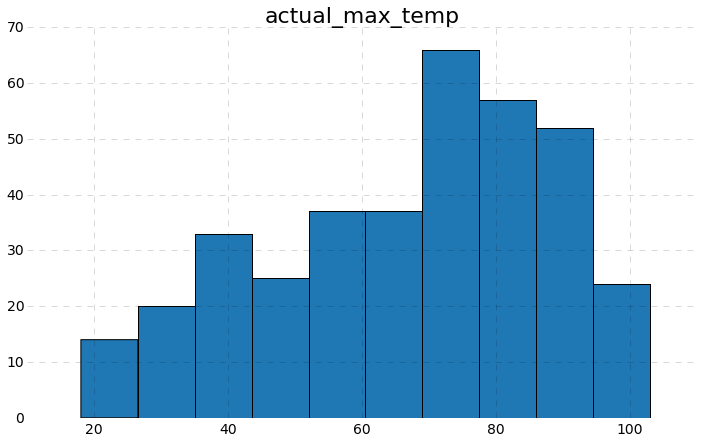

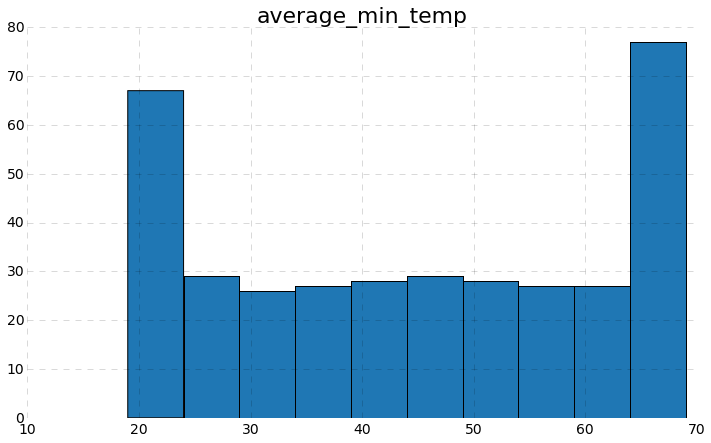

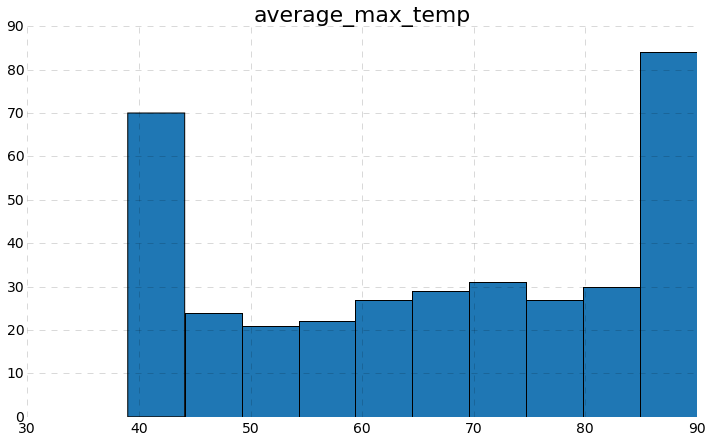

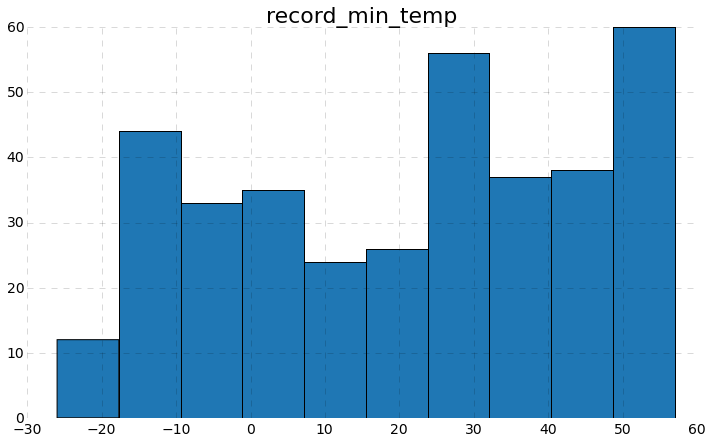

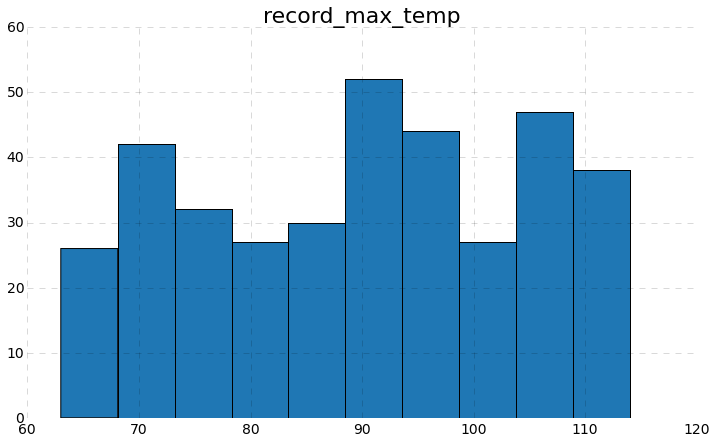

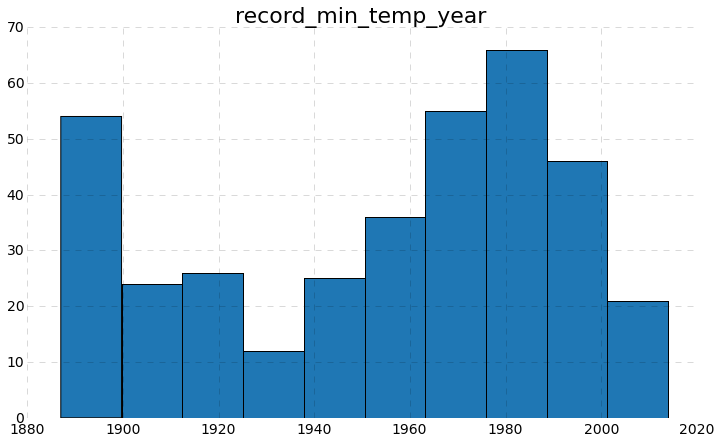

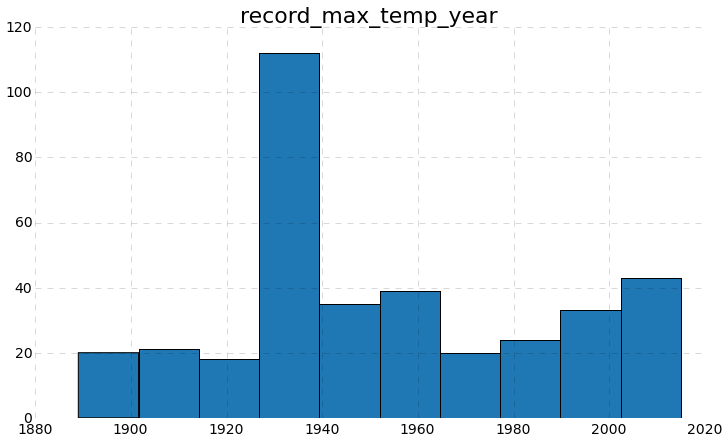

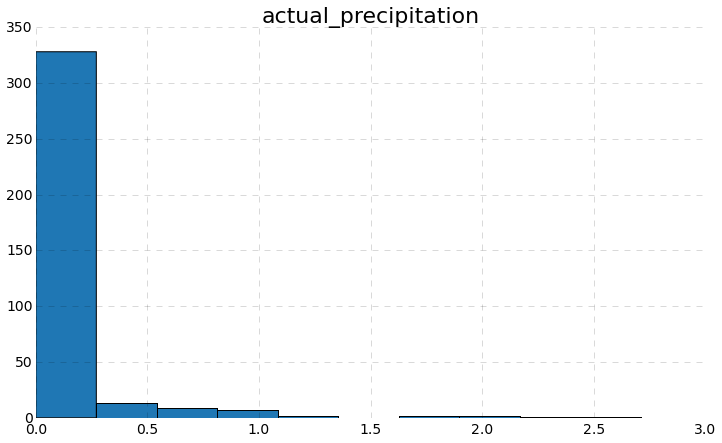

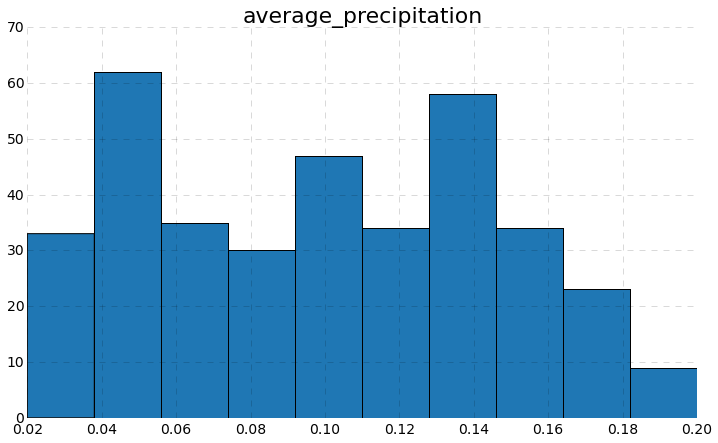

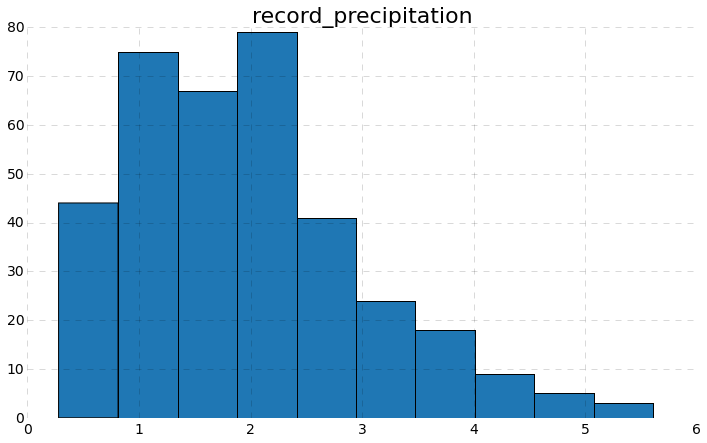

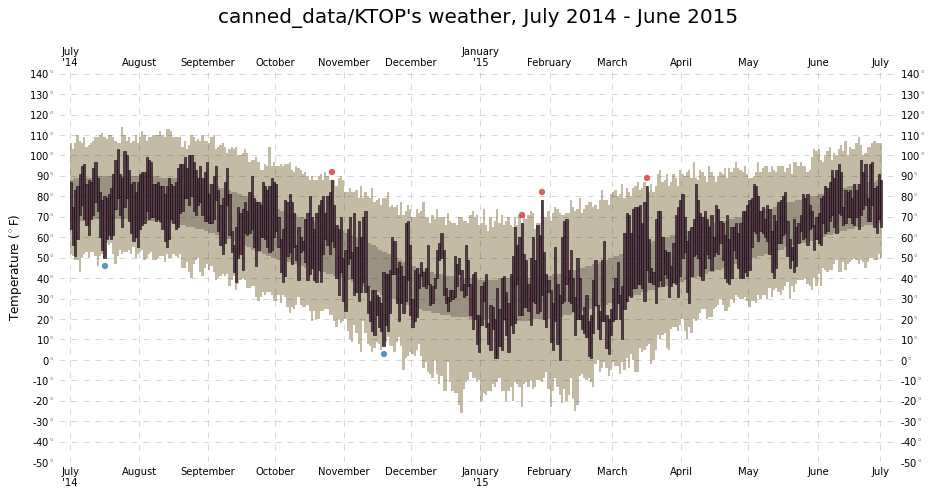

In [13]:
visualize_station('canned_data/KTOP')

# KTTN Trenton, New Jersey

       actual_mean_temp  actual_min_temp  actual_max_temp  average_min_temp  \
count        365.000000       365.000000       365.000000        365.000000   
mean          53.082192        43.643836        62.002740         44.136986   
std           18.908799        18.320236        20.029717         14.889442   
min            8.000000         0.000000        16.000000         23.000000   
25%           37.000000        30.000000        43.000000         30.000000   
50%           56.000000        45.000000        67.000000         43.000000   
75%           70.000000        60.000000        80.000000         59.000000   
max           83.000000        74.000000        93.000000         67.000000   

       average_max_temp  record_min_temp  record_max_temp  \
count        365.000000       365.000000       365.000000   
mean          62.986301        26.380822        84.282192   
std           16.327598        19.748144        12.502740   
min           39.000000       -14.000000    

/Users/mglerner/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


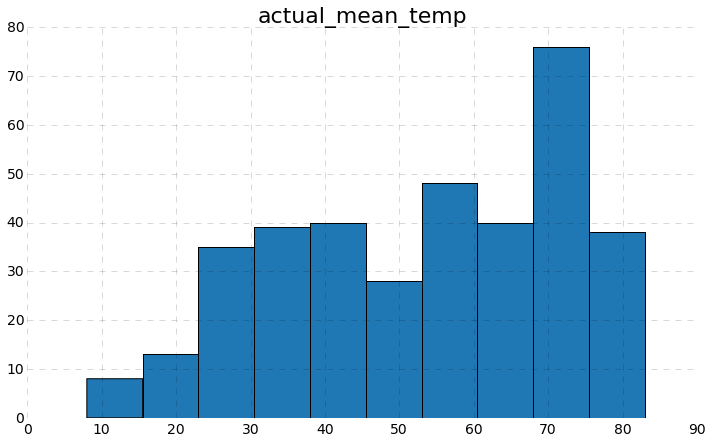

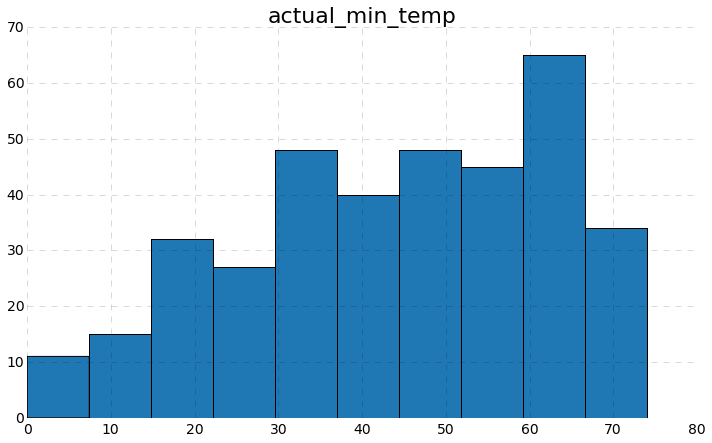

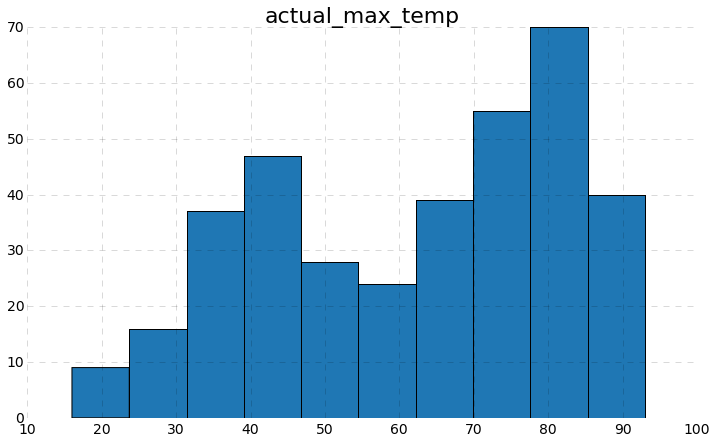

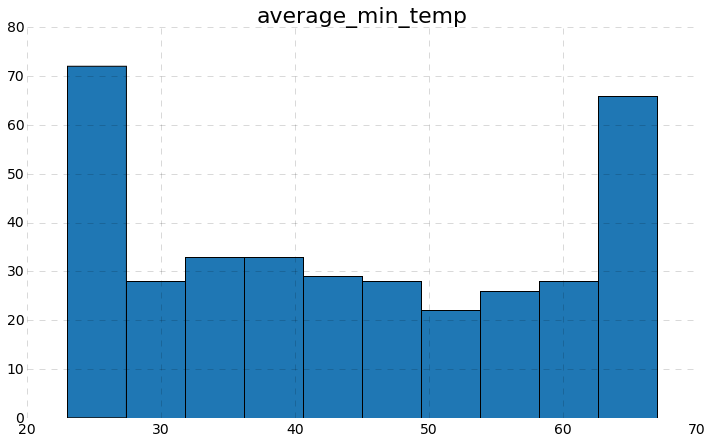

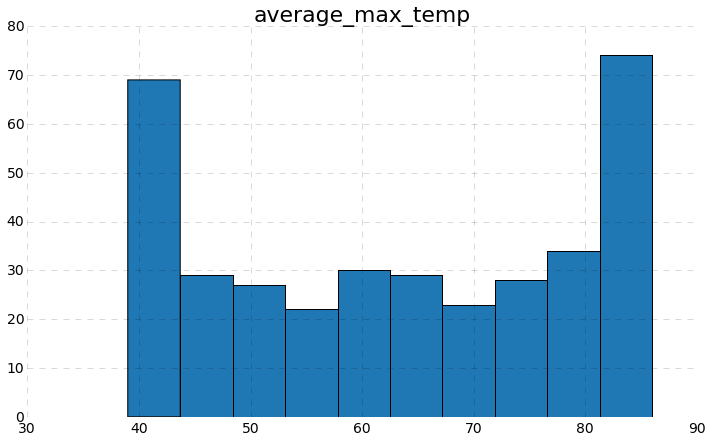

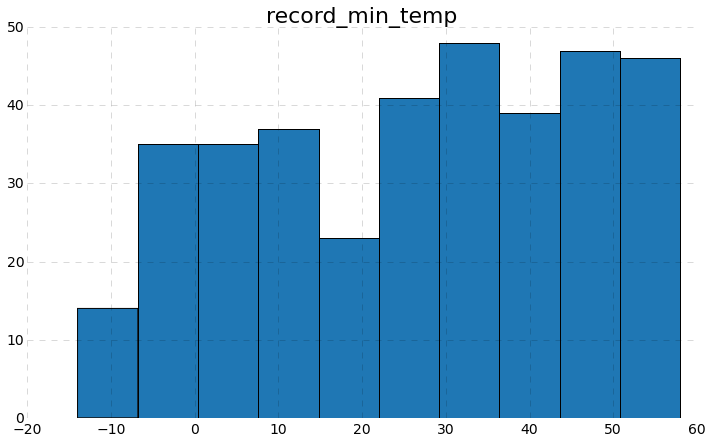

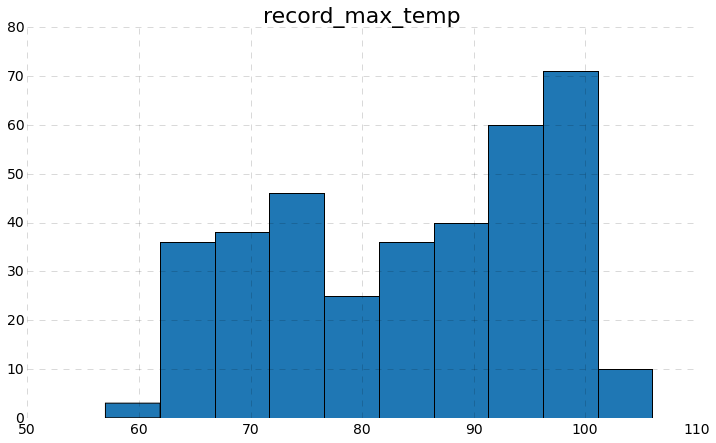

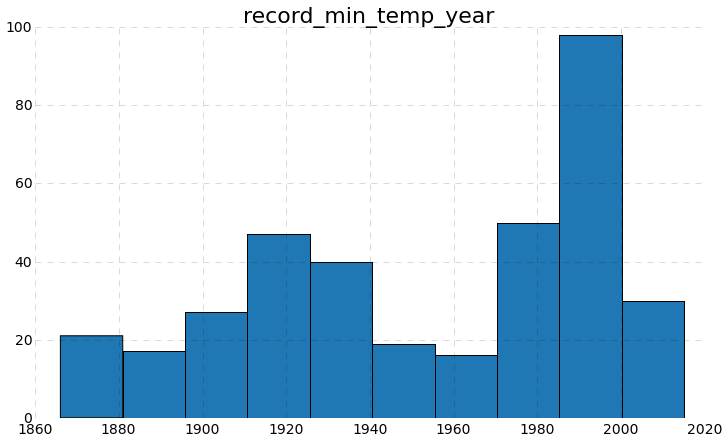

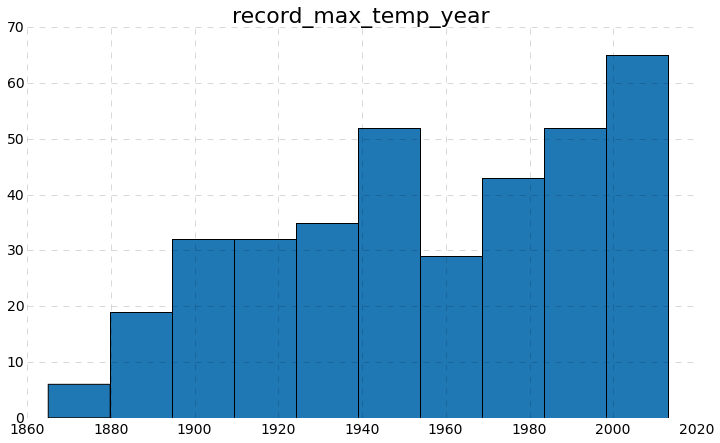

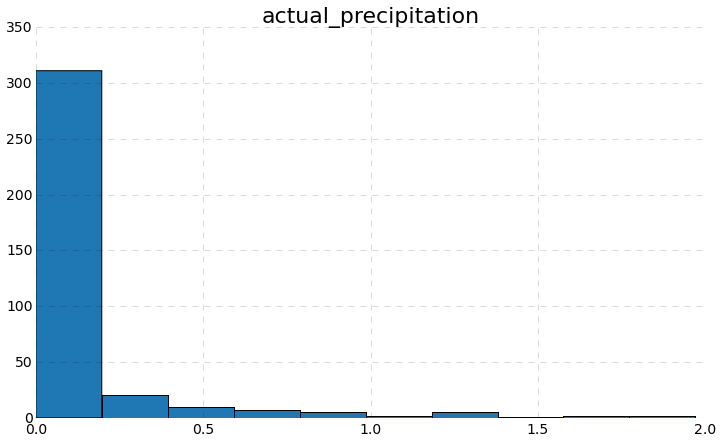

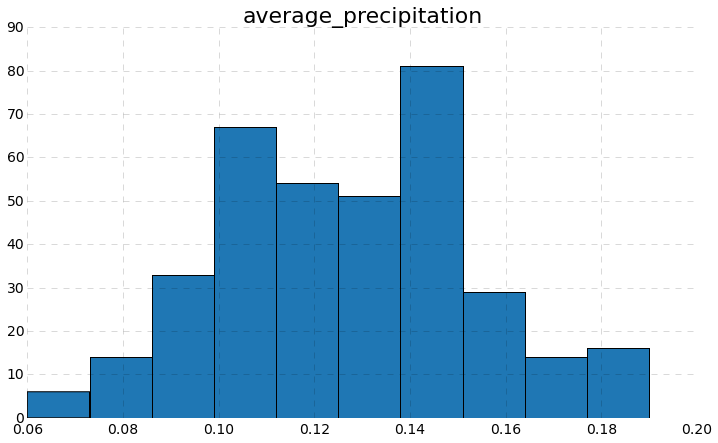

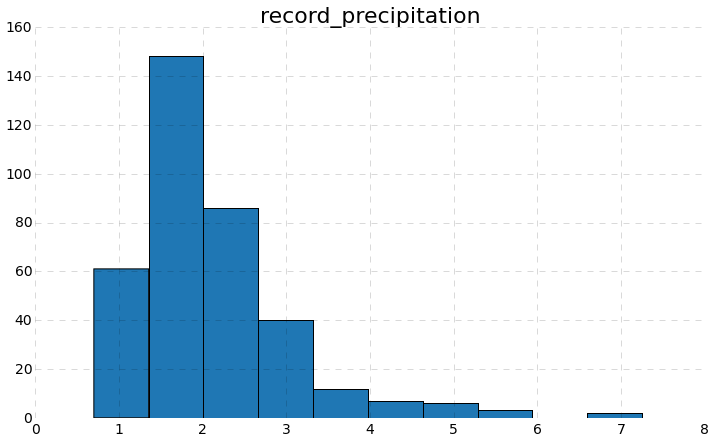

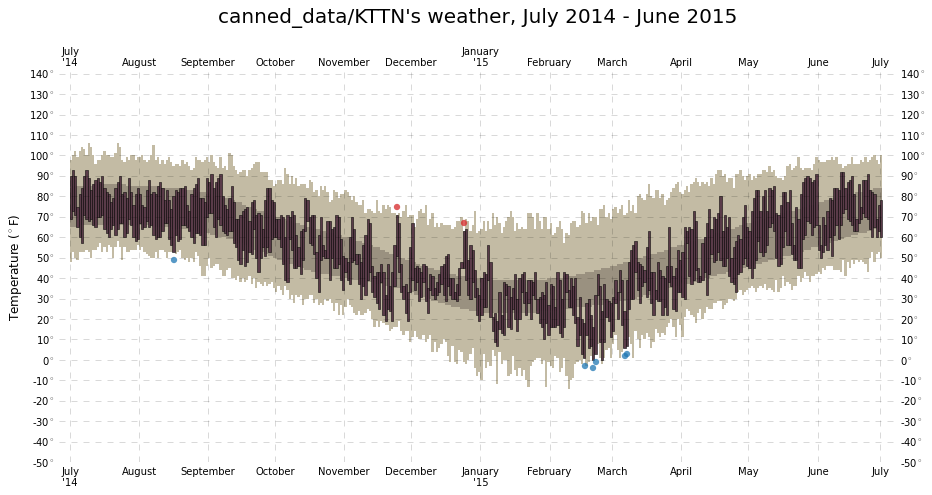

In [14]:
visualize_station('canned_data/KTTN')